# Preparing 'Coronary artery disease (CAD) 1 million hearts' SumStats for GWAS Catalog

This notebook serves to inspect `CHD_meta_SAIGE_complete_filtered_30.1.19.out.gz`, and proceses the meta-analysis GWAS data for sharing through _FUMA_ and for (in-house) downstream analyses.

Phenotypes:

- CAD

## Header of the file

```
MarkerName	CHR	BP	Allele1	Allele2	Freq1	FreqSE	MinFreq	MaxFreq	Effect	StdErr	P-value	Direction	HetISq	HetChiSq	HetDf	HetPVal	Cases	Effective_Cases	N	Meta_analysis
1:61743_C_G	1	61743	c	g	0.0061	0.0009	0.0019	0.0064	-0.11632669	0.079006163	0.1409	-???????+??	0.0	0.561	1	0.454	41651	18141.4	538622	Cardiogram
1:88370_A_G	1	88370	a	g	0.0033	0.0004	0.0019	0.0034	-0.011699052	0.093564733	0.9005	-???????+??	51.8	2.077	1	0.1496	41651	22939.1	538622	Cardiogram
```

Order of studies in the 3 meta-analyses (1000G, Metabo, Exome) is as follows:

- 1000G c.q. Cardiogram (n=11): UKBB-SAIGE, 1000G, EPIC, GerMIFs5, GerMIFs6, GerMIFs7, deCODE, Greek, HUNT-SAIGE, Partners, TIMI
- Exome (n=11): UKBB-SAIGE, Exome, GerMIFs1, GerMIFS2, GerMIFs5, GerMIFs6, GerMIFs7, Greek, deCODE, Partners, TIMI
- Metabo (n=10): UKBB-SAIGE, Metabo, GerMIFs4, GerMIFs5, GerMIFs6, GerMIFs7, Greek, HUNT-SAIGE, Partners, TIMI

This data was updated on 1st February 2019 with updated meta-analysis results (including TIMI and SAIGE versions of HUNT and UK Biobank) after implementing a post-meta-analysis QC filter, which requires a variant with p<1e-5 from the meta-analysis to have at least 2 studies in the same direction of effect as the overall meta-analysis, and the 2nd largest p-value being less than 0.2. This removes clearly erroneous variants but doesn't remove very many variants in known loci which
could be true positives.
(NB: this version of the file also corrects the scientific notation introduced into some of the markernames in previous versions of the meta-analysis results and the incorrect frequencies from a bug with the TIMI results)

The updated full meta-analysis results are in 'CHD_meta_SAIGE_complete_filtered_30.1.19.out.gz'.

Results are in standard METAL format where Allele1 is the 'effect allele' that the effect and frequency columns refer to.
Bespoke columns are:

- 'Effective_cases', which is the sum of the effective number of cases (calculated as variant-specific info\*number of cases, with info=1 for genotyped) across studies.
- 'Meta_analysis', which lists whether the final result for that variant was from the Cardiogram 1000G, Metabo or Exome meta-analysis (based on maximum number of effective cases)
  The order of the studies in the Direction column is at the bottom of this file.


## Import necessary libraries


In [1]:
# Function to check for installation of required packages
def check_install_package(package_name):
    try:
        importlib.import_module(package_name)
    except ImportError:
        print(f'{package_name} is not installed. Installing it now...')
        subprocess.check_call(['pip', 'install', package_name])

import os
import glob
import importlib
import subprocess
import sys

# argument parsing
import argparse

# get date and time
from datetime import datetime

# Pandas is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool
# check_install_package('pandas')
import pandas as pd

# pyarrow is supperior to loading parquet files
# check_install_package('pyarrow')
import pyarrow as pa
import pyarrow.parquet as pq

# polars is a fast dataframe library
#check_install_package('polars-lts-cpu')
import polars as pl

# for statistical analysis
# check_install_package('scipy')
from scipy import stats
import numpy as np

# scientific colourmaps
# https://www.fabiocrameri.ch/ws/media-library/8c4b111121ff448e843dfef9220bf613/readme_scientificcolourmaps.pdf
# check_install_package('cmcrameri')
import cmcrameri as ccm
from cmcrameri import cm

# for plotting
# check_install_package('matplotlib')
import matplotlib
import matplotlib.pyplot as plt
# if using a Jupyter notebook, include:
%matplotlib inline

# use Seaborn for visualisations
# check_install_package('seaborn')
import seaborn as sns


In [3]:
# for handling GWAS data
import gwaslab as gl

Creating directories for plots


In [4]:
# Create directories for the GWAS data and the reference data
import os
from subprocess import check_output

# set some general defaults
SUBSTUDY_PHENO = "CAD1Million"

POPULATION = "EUR"

PHENOTYPE = "CAD"

SEX = "BOTH"

SEX1 = "FEMALE"

SEX2= "MALE"

REF_1KG = "1kg_eur_hg19"

# general plotting directory
PLOTS_loc = "PLOTS"

# Check if the directory exists
if not os.path.exists(PLOTS_loc):
    # If it doesn't exist, create it
    os.makedirs(PLOTS_loc)

# regional association plots directory
REG_PLOTS_loc = PLOTS_loc + "/Regional_Association_Plots"

# Check if the directory exists
if not os.path.exists(REG_PLOTS_loc):
    # If it doesn't exist, create it
    os.makedirs(REG_PLOTS_loc)

# Reference data directory
REF_loc = "/Users/slaan3/PLINK/references"
print("Checking contents of the reference directory:")
print(check_output(["ls", os.path.join(REF_loc)]).decode("utf8"))

# GWAS data directory
GWAS_RES_loc = "/Users/slaan3/PLINK/_GWAS_Datasets/_CARDIoGRAM/millionhearts"
print("Checking contents of the GWAS results directory:")
print(check_output(["ls", os.path.join(GWAS_RES_loc)]).decode("utf8"))

# Check if the directory exists
if not os.path.exists("GWASCatalog"):
    # If it doesn't exist, create it
    os.makedirs("GWASCatalog")

# GWAS Catalog directory
GWASCatalog_loc = os.path.join("GWASCatalog")

Checking contents of the reference directory:
1000G
GoNL
HRC_r1_1_2016
HRCr11_1000Gp3v5
dbSNP
fasta
refgenie_genomes
tcga

Checking contents of the GWAS results directory:
CHD_meta_SAIGE_complete_filtered_30.1.19.out.gz
CHD_meta_SAIGE_complete_filtered_30.1.19.out.readme.txt
top_hits_cad_Chen_Z_ea_JIM_2021.txt



# Loading CAD1M

We load in the GWAS on CAD1M.


In [28]:
# read in data
# https://stackoverflow.com/questions/33813815/how-to-read-a-parquet-file-into-pandas-dataframe

import os
import polars as pl

# Explicitly define the correct data types for certain columns
# There is an error at import (from temp to pandas()):
    # Could not parse `X` as dtype `i64` at column 'CHR' (column number 2)
    # https://stackoverflow.com/questions/75797640/how-to-specify-column-types-in-python-polars-read-csv
    # https://stackoverflow.com/questions/71790235/switching-between-dtypes-within-a-dataframe
    # https://pola-rs.github.io/polars/user-guide/concepts/data-types/
dtypes = {
    "CHR": pl.Utf8,
    "BP": pl.Int64,
    "Freq1": pl.Float64,
    "FreqSE": pl.Float64,
    "MinFreq": pl.Float64,
    "MaxFreq": pl.Float64,
    "Effect": pl.Float64,
    "StdErr": pl.Float64,
    "P-value": pl.Float64,
    "Cases": pl.Float64,  # Since there are decimal cases
    "Effective_Cases": pl.Float64,
    "N": pl.Float64,
}

temp = pl.read_csv(
    source=os.path.join(GWAS_RES_loc, "CHD_meta_SAIGE_complete_filtered_30.1.19.out.gz"),
    has_header=True,
    separator="\t",
    ignore_errors=False,
    dtypes=dtypes,  # Assigning the defined data types
    # n_rows=1000, # for debugging
    null_values=["NA"], # necessary to fix issues with missing values when reading data
    quote_char=None,
)


/var/folders/mm/b4fx9qss7t79pb95gn3k6grh0000gq/T/ipykernel_16178/170960913.py:28: DeprecationWarning: The argument `dtypes` for `read_csv` is deprecated. It has been renamed to `schema_overrides`.
  temp = pl.read_csv(


In [29]:
# Convert Allele1 and Allele2 to uppercase
temp = temp.with_columns([
    pl.col("Allele1").str.to_uppercase(),
    pl.col("Allele2").str.to_uppercase(),
])

# Replace "_" with ":" in MarkerName and add "chr" as a prefix
temp = temp.with_columns([
    pl.format("chr{}", pl.col("MarkerName").str.replace_all("_", ":")).alias("MarkerName")
])

In [31]:
# Ensure Meta_analysis is of string type using with_columns
temp = temp.with_columns(
    pl.col("Meta_analysis").cast(pl.Utf8)
)

In [32]:
# Define the mapping for cohort values
# https://stackoverflow.com/questions/74779644/mapping-a-python-dict-to-a-polars-series
cohort_mapping = {
    "Cardiogram": "UKBB-SAIGE, 1000G, EPIC, GerMIFs5, GerMIFs6, GerMIFs7, deCODE, Greek, HUNT-SAIGE, Partners, TIMI",
    "Exome": "UKBB-SAIGE, Exome, GerMIFs1, GerMIFS2, GerMIFs5, GerMIFs6, GerMIFs7, Greek, deCODE, Partners, TIMI",
    "Metabo": "UKBB-SAIGE, Metabo, GerMIFs4, GerMIFs5, GerMIFs6, GerMIFs7, Greek, HUNT-SAIGE, Partners, TIMI"
}
# Use map_dict to map the Meta_analysis column
temp = temp.with_columns(
    pl.col("Meta_analysis").replace(cohort_mapping, default="CAD1M").alias("Cohorts")
)

/var/folders/mm/b4fx9qss7t79pb95gn3k6grh0000gq/T/ipykernel_16178/3572233791.py:10: DeprecationWarning: The `default` parameter for `replace` is deprecated. Use `replace_strict` instead to set a default while replacing values.
  pl.col("Meta_analysis").replace(cohort_mapping, default="CAD1M").alias("Cohorts")


In [33]:
# Define the mapping for renaming columns
rename_mapping = {
    "Allele1": "effect_allele",
    "Allele2": "other_allele",
    "Freq1": "EAF",
    "FreqSE": "EAFse",
    "MinFreq": "minEAF",
    "MaxFreq": "maxEAF"
}

# Rename the columns using the mapping
temp = temp.rename(rename_mapping)

In [34]:
# Convert Polars dataframe to pandas dataframe
cad1m_data = temp.to_pandas()

In [35]:
del temp

## Inspection of data

Here we do a quick check on what is what in the data.


### Heads

Printing head of data.


In [36]:
cad1m_data.head()

,MarkerName,CHR,BP,effect_allele,other_allele,EAF,EAFse,minEAF,maxEAF,Effect,...,Direction,HetISq,HetChiSq,HetDf,HetPVal,Cases,Effective_Cases,N,Meta_analysis,Cohorts
0,chr1:61743:C:G,1,61743,C,G,0.0061,0.0009,0.0019,0.0064,-0.116327,...,-???????+??,0.0,0.561,1,0.45400,41651.0,18141.4,538622.0,Cardiogram,"UKBB-SAIGE, 1000G, EPIC, GerMIFs5, GerMIFs6, G..."
1,chr1:88370:A:G,1,88370,A,G,0.0033,0.0004,0.0019,0.0034,-0.011699,...,-???????+??,51.8,2.077,1,0.14960,41651.0,22939.1,538622.0,Cardiogram,"UKBB-SAIGE, 1000G, EPIC, GerMIFs5, GerMIFs6, G..."
2,chr1:108382:A:C,1,108382,A,C,0.0008,0.0000,0.0007,0.0008,0.263852,...,+???????-??,0.0,0.932,1,0.33440,41651.0,26336.9,538622.0,Cardiogram,"UKBB-SAIGE, 1000G, EPIC, GerMIFs5, GerMIFs6, G..."
3,chr1:233476:A:G,1,233476,A,G,0.0055,0.0012,0.0049,0.0081,0.094606,...,+???????-??,63.1,2.713,1,0.09955,41651.0,17869.6,538622.0,Cardiogram,"UKBB-SAIGE, 1000G, EPIC, GerMIFs5, GerMIFs6, G..."
4,chr1:526832:C:G,1,526832,C,G,0.0367,0.0076,0.0271,0.0427,-0.001923,...,+?????-????,0.0,0.584,1,0.44480,72859.0,50163.8,829210.0,Cardiogram,"UKBB-SAIGE, 1000G, EPIC, GerMIFs5, GerMIFs6, G..."


### Shapes

Printing shapes of data.


In [37]:
print("Printing shape of data:\n", cad1m_data.shape)

Printing shape of data:
 (20073070, 22)


### Columns

Printing columns of data.


In [38]:
print("Printing columns of data:\n", cad1m_data.columns)

Printing columns of data:
 Index(['MarkerName', 'CHR', 'BP', 'effect_allele', 'other_allele', 'EAF',
       'EAFse', 'minEAF', 'maxEAF', 'Effect', 'StdErr', 'P-value', 'Direction',
       'HetISq', 'HetChiSq', 'HetDf', 'HetPVal', 'Cases', 'Effective_Cases',
       'N', 'Meta_analysis', 'Cohorts'],
      dtype='object')


### Info

Printing info of data.


In [39]:
print("Printing info of data:\n", cad1m_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20073070 entries, 0 to 20073069
Data columns (total 22 columns):
 #   Column           Dtype  
---  ------           -----  
 0   MarkerName       object 
 1   CHR              object 
 2   BP               int64  
 3   effect_allele    object 
 4   other_allele     object 
 5   EAF              float64
 6   EAFse            float64
 7   minEAF           float64
 8   maxEAF           float64
 9   Effect           float64
 10  StdErr           float64
 11  P-value          float64
 12  Direction        object 
 13  HetISq           float64
 14  HetChiSq         float64
 15  HetDf            int64  
 16  HetPVal          float64
 17  Cases            float64
 18  Effective_Cases  float64
 19  N                float64
 20  Meta_analysis    object 
 21  Cohorts          object 
dtypes: float64(13), int64(2), object(7)
memory usage: 3.3+ GB
Printing info of data:
 None


### Column statistics

Getting some per column summary statistics of data.


In [40]:
print("Printing describe of data:\n", cad1m_data.describe())

Printing describe of data:
                  BP           EAF         EAFse        minEAF        maxEAF  \
count  2.007307e+07  2.007307e+07  2.007307e+07  2.007307e+07  2.007307e+07   
mean   7.899803e+07  4.331528e-01  9.692813e-03  4.174549e-01  4.491971e-01   
std    5.629220e+07  4.266593e-01  1.712309e-02  4.241556e-01  4.268953e-01   
min    5.200000e+01  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e-04   
25%    3.274436e+07  7.500000e-03  6.000000e-04  2.300000e-03  9.900000e-03   
50%    6.963363e+07  2.682000e-01  3.400000e-03  2.333000e-01  3.002000e-01   
75%    1.147473e+08  9.595000e-01  1.240000e-02  9.192000e-01  9.781000e-01   
max    2.492393e+08  1.000000e+00  4.996000e-01  9.999000e-01  1.000000e+00   

             Effect        StdErr        P-value        HetISq      HetChiSq  \
count  2.007307e+07  2.007307e+07   2.007307e+07  2.007307e+07  2.007307e+07   
mean   2.841987e-04  6.735252e-02   4.788216e-01  1.311673e+01  4.620753e+00   
std    1.024521e-01 

### Basic visualisations

Here we plot histograms of allele frequencies, effect, and sample size .


#### Sampling from the data

Here we provide an example on how to take a sample of n=800,000 rows, representing ±10% of the data, for easy plotting. This should be representative for most things we are interested in.


In [41]:
# example code to get a sample
cad1m_data_sample = cad1m_data.sample(800000)

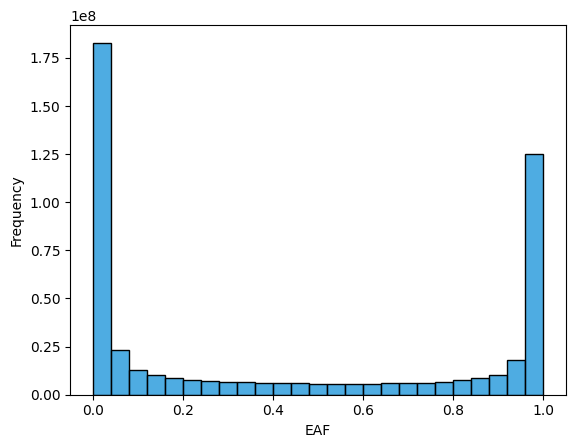

In [42]:
import seaborn as sns

sns.histplot(
    data=cad1m_data,  # gwas_combo_sample,
    x="EAF",
    bins=25,
    kde=False,
    stat="frequency",
    color="#1290D9",
)

# plt.savefig(
#     os.path.join(PLOTS_loc, "histogram.EAF.WOMEN." + POPULATION + ".png"),
#     dpi=300,
#     bbox_inches="tight",
#     format="png",
# )
plt.savefig(
    os.path.join(PLOTS_loc, "histogram.EAF." + PHENOTYPE + "_" + SEX + "_" + POPULATION + ".pdf"),
    dpi=300,
    bbox_inches="tight",
    format="pdf",
)

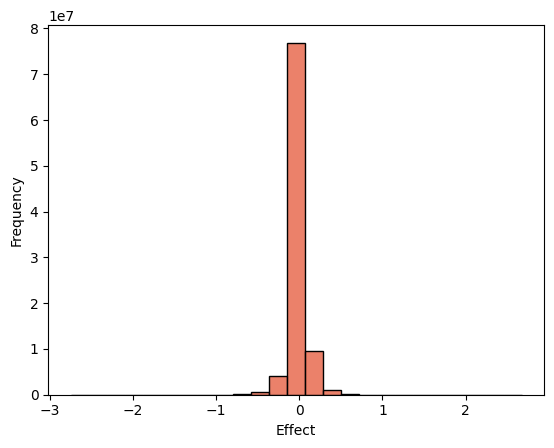

In [43]:
sns.histplot(
    data=cad1m_data,  # gwas_combo_sample,
    x="Effect",
    bins=25,
    kde=False,
    stat="frequency",
    color="#E55738",
)

# plt.savefig(
#     os.path.join(PLOTS_loc, "histogram.effect.WOMEN." + POPULATION + ".png"),
#     dpi=300,
#     bbox_inches="tight",
#     format="png",
# )
plt.savefig(
    os.path.join(PLOTS_loc, "histogram.effect." + PHENOTYPE + "_" + SEX + "_" + POPULATION + ".pdf"),
    dpi=300,
    bbox_inches="tight",
    format="pdf",
)

### SumStats quality control

Here we first check and fix headers, _if_ needed, and contents of the SumStats object.

First, we load the data and inspect it using `GWASLab`. Note that for this to work, some column types need to be adjusted.

```
 RangeIndex: 20073070 entries, 0 to 20073069
Data columns (total 22 columns):
 #   Column           Dtype
---  ------           -----
 0   MarkerName       object
 1   CHR              object
 2   BP               int64
 3   effect_allele    object
 4   other_allele     object
 5   EAF              float64
 6   EAFse            float64
 7   minEAF           float64
 8   maxEAF           float64
 9   Effect           float64
 10  StdErr           float64
 11  P-value          float64
 12  Direction        object
 13  HetISq           float64
 14  HetChiSq         float64
 15  HetDf            int64
 16  HetPVal          float64
 17  Cases            float64
 18  Effective_Cases  float64
 19  N                float64
 20  Meta_analysis    object
 21  Cohorts          object
dtypes: float64(13), int64(2), object(7)
```


In [ ]:
# cad1m_data[["CHR"]] = cad1m_data[["CHR"]].astype("object")

In [ ]:
# cad1m_data[["POS"]] = cad1m_data[["POS"]].astype("Int64")

In [ ]:
# # create new SNPID column based on chromosome, position, and alleles
# # down the road we need an SNPID column to merge with the reference data and which does not contain 'ID' because this is not correctly interpreted by GWASLab
# cad1m_data["SNPID"] = (
#     cad1m_data["CHR"].astype(str)
#     + ":"
#     + cad1m_data["POS"].astype(str)
#     + ":"
#     + cad1m_data["OTHERALLELE"].astype(str)
#     + ":"
#     + cad1m_data["CODEDALLELE"].astype(str)
# )

# # create sample size if it does not exist
# # cad1m_data["N"] = 5344

In [ ]:
# cad1m_data.head()

In [ ]:
# cad1m_data.rename(columns={"SNP": "VariantID"}, inplace=True)

### Converting to GWASLab object

Here we are ready to load the data and inspect it using `GWASLab`.


In [76]:
# cad1m_sumstats.data

In [46]:
import gwaslab as gl

# Specify the columns:
cad1m_sumstats = gl.Sumstats(
    cad1m_data,
    snpid="MarkerName",
    # rsid="RSID", # not available
    chrom="CHR",
    pos="BP",
    ea="effect_allele",
    nea="other_allele",
    eaf="EAF",
    beta="Effect",
    se="StdErr",
    p="P-value",
    direction="Direction",  # only for meta-GWAS
    n="N",
    # info="Info", # not available
    other=[
        "Cases",
        "Effective_Cases",
        "HetPVal",
        "HetISq",
        "Meta_analysis",
        "Cohorts",
    ],
    build="19",
    verbose=True,
)

2024/10/18 11:05:00 GWASLab v3.4.46 https://cloufield.github.io/gwaslab/
2024/10/18 11:05:00 (C) 2022-2024, Yunye He, Kamatani Lab, MIT License, gwaslab@gmail.com
2024/10/18 11:05:00 Start to initialize gl.Sumstats from pandas DataFrame ...
2024/10/18 11:05:26  -Reading columns          : CHR,BP,N,EAF,Effective_Cases,Effect,effect_allele,Direction,other_allele,StdErr,Meta_analysis,Cases,HetISq,Cohorts,P-value,MarkerName,HetPVal
2024/10/18 11:05:26  -Renaming columns to      : CHR,POS,N,EAF,Effective_Cases,BETA,EA,DIRECTION,NEA,SE,Meta_analysis,Cases,HetISq,Cohorts,P,SNPID,HetPVal
2024/10/18 11:05:26  -Current Dataframe shape : 20073070  x  17
2024/10/18 11:05:49  -Initiating a status column: STATUS ...
2024/10/18 11:05:49  -Genomic coordinates are based on GRCh37/hg19...
2024/10/18 11:05:59 Start to reorder the columns...v3.4.46
2024/10/18 11:05:59  -Current Dataframe shape : 20073070 x 18 ; Memory usage: 2511.71 MB
2024/10/18 11:05:59  -Reordering columns to    : SNPID,CHR,POS,EA,NEA,

In [48]:
cad1m_sumstats.summary()

Values  \
Category Items                                                                  
META     Row_num                                                     20073070   
         Column_num                                                        18   
         Column_names       SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,N,DIRECTION...   
         Last_checked_time                           Fri Oct 18 11:49:40 2024   
MISSING  Missing_total                                                      0   
MAF      Common                                                       7181902   
         Low_frequency                                                3930695   
         Rare                                                         8945610   
P        Minimum                                                    4.99e-278   
         Significant                                                    18348   
         Suggestive                                                     33786   
STATUS   1999999                                                     20073070   

                            Percentage  
Category Items                          
META     Row_num                  <NA>  
         Column_num               <NA>  
         Column_names             <NA>  
         Last_checked_time        <NA>  
MISSING  Missing_total             0.0  
MAF      Common                  35.78  
         Low_frequency           19.58  
         Rare                    44.57  
P        Minimum                   0.0  
         Significant              0.09  
         Suggestive               0.17  
STATUS   1999999                 100.0

In [47]:
cad1m_sumstats.lookup_status()

,Genome_Build,rsID&SNPID,CHR&POS,Stadardize&Normalize,Align,Panlidromic_SNP&Indel,Count,Percentage(%)
1999999,hg19,Unchecked,Unchecked,Unchecked,Unchecked,Unchecked,20073070,100.0


#### Intermediate cleaning

Here we cleanup the originally loaded data, to clear memory.


In [49]:
del cad1m_data

#### Get reference data

We align the data to the reference genome, this will work for most common variants. Before that, we check which reference datasets are available, and get these.


In [50]:
# check references
gl.check_available_ref()

# {'1kg_eas_hg19': 'https://www.dropbox.com/s/lztaxqhy2o6dpxw/EAS.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?dl=1',
#  '1kg_eas_hg19_md5': 'c8c97434843c0da3113fc06879ead472',
#  '1kg_eas_hg19_tbi': 'https://www.dropbox.com/s/k9klefl8m9fcfo1/EAS.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?dl=1',
#  '1kg_eur_hg19': 'https://www.dropbox.com/s/1nbgqshknevseks/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?dl=1',
#  '1kg_eur_hg19_md5': '734069d895009d38c2f962bfbb6fab52',
#  '1kg_eur_hg19_tbi': 'https://www.dropbox.com/s/vscvkrflh6fc5a0/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?dl=1',
#  '1kg_eas_hg38': 'https://www.dropbox.com/s/3dstbbb1el9r3au/EAS.ALL.split_norm_af.1kg_30x.hg38.vcf.gz?dl=1',
#  '1kg_eas_hg38_md5': 'f45e80bca9ef7b29e6b1832e6ac15375',
#  '1kg_eas_hg38_tbi': 'https://www.dropbox.com/s/vwnp5vd8dcqksn4/EAS.ALL.split_norm_af.1kg_30x.hg38.vcf.gz.tbi?dl=1',
#  '1kg_eur_hg38': 'https://www.dropbox.com/s/z0mkehg17lryapv/EUR.ALL.split_norm_af.1kg_30x.hg38.vcf.gz?dl=1',
#  '1kg_eur_hg38_md5': '228d3285fa99132cc6321e2925e0768d',
#  '1kg_eur_hg38_tbi': 'https://www.dropbox.com/s/ze8g58x75x9qbf0/EUR.ALL.split_norm_af.1kg_30x.hg38.vcf.gz.tbi?dl=1',
#  '1kg_sas_hg19': 'https://www.dropbox.com/scl/fi/fubqvuj3p4ii4y35zknv8/SAS.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?rlkey=5z50f66iltjchcaszznq5bczt&dl=1',
#  '1kg_sas_hg19_md5': 'e2d3f9e2e6580d05e877e9effd435c4e',
#  '1kg_sas_hg19_tbi': 'https://www.dropbox.com/scl/fi/icnmrnzee7ofdpx5l96tg/SAS.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?rlkey=st8t88snby26q37rqi6zh5zck&dl=1',
#  '1kg_amr_hg19': 'https://www.dropbox.com/scl/fi/bxa4zfngsxsc38rhtiv8c/AMR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?rlkey=ibcn8hb1n8n36j3u0jfzci267&dl=1',
#  '1kg_amr_hg19_md5': '68d3cdf01cbabdae6e74a07795fa881c',
#  '1kg_amr_hg19_tbi': 'https://www.dropbox.com/scl/fi/1zk16x7h4r89jurzwu05u/AMR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?rlkey=b4cere4w38zvzyfitfge3r8n0&dl=1',
#  '1kg_sas_hg38': 'https://www.dropbox.com/scl/fi/jr3l5zz42py3kny2bccmj/SAS.ALL.split_norm_af.1kg_30x.hg38.vcf.gz?rlkey=x0t6tsy71jxzf021wfqdn8k5q&dl=1',
#  '1kg_sas_hg38_md5': 'e5d79bea1958aa50c23f618d342ccc83',
#  '1kg_sas_hg38_tbi': 'https://www.dropbox.com/scl/fi/02oia4ur5r7w9qgiuf6i9/SAS.ALL.split_norm_af.1kg_30x.hg38.vcf.gz.tbi?rlkey=00p9rxe0xzfs6hr1rg4d8oadm&dl=1',
#  '1kg_amr_hg38': 'https://www.dropbox.com/scl/fi/4t4tyuhzp78uyb6tgkroq/AMR.ALL.split_norm_af.1kg_30x.hg38.vcf.gz?rlkey=p96gbs1tcdia31jnjv1b82kuz&dl=1',
#  '1kg_amr_hg38_md5': '229fbd610001cf6f137b7f738352a44a',
#  '1kg_amr_hg38_tbi': 'https://www.dropbox.com/scl/fi/x0dby543tr9xpaqj2i0ba/AMR.ALL.split_norm_af.1kg_30x.hg38.vcf.gz.tbi?rlkey=uj8o7j0cy0spipe174jn54sqs&dl=1',
#  '1kg_afr_hg19': 'https://www.dropbox.com/scl/fi/tq4w9lyt5z47ym7grtrxg/AFR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?rlkey=k3bimeu3yr5loq8hohba5mr6k&dl=1',
#  '1kg_afr_hg19_md5': 'f7b4425f39e8292dce6f13711e7f6c50',
#  '1kg_afr_hg19_tbi': 'https://www.dropbox.com/scl/fi/0giiptu0btwj1kfm6jdzr/AFR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?rlkey=ucb5weprsc5prcg8hvtgmruxx&dl=1',
#  '1kg_pan_hg19': 'https://www.dropbox.com/scl/fi/6b4j9z9knmllfnbx86aw6/PAN.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?rlkey=eento8vg06zyrkvooc9wd4cvu&dl=1',
#  '1kg_pan_hg19_md5': 'fed846482204487b60d33b21ddb18106',
#  '1kg_pan_hg19_tbi': 'https://www.dropbox.com/scl/fi/stco946scio5tvto0ln4j/PAN.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?rlkey=hfh53beb627lmqwv3d8mzqy0c&dl=1',
#  '1kg_afr_hg38': 'https://www.dropbox.com/scl/fi/239xmm7qijtnsks97chc9/AFR.ALL.split_norm_af.1kg_30x.hg38.vcf.gz?rlkey=47en5fk1icbekpg7we3uot9g8&dl=1',
#  '1kg_afr_hg38_md5': '3bb7923be0809a324d7b7633b8d58a3b',
#  '1kg_afr_hg38_tbi': 'https://www.dropbox.com/scl/fi/3y3pg4yqwo2jaaamx1c8f/AFR.ALL.split_norm_af.1kg_30x.hg38.vcf.gz.tbi?rlkey=say0ihfwa51z3otgn4bjtze8p&dl=1',
#  '1kg_pan_hg38': 'https://www.dropbox.com/scl/fi/nf01487smtmeq243ihfwm/PAN.ALL.split_norm_af.1kg_30x.hg38.vcf.gz?rlkey=3pefbkzxwcnejx4inynifpft7&dl=1',
#  '1kg_pan_hg38_md5': '23bb86d748c4a66e85e087f647e8b60e',
#  '1kg_pan_hg38_tbi': 'https://www.dropbox.com/scl/fi/hu7cttr4cenw5yjsm2775/PAN.ALL.split_norm_af.1kg_30x.hg38.vcf.gz.tbi?rlkey=568u7bkvkybm4wt2q9284o198&dl=1',
#  '1kg_eas_x_hg19': 'https://www.dropbox.com/scl/fi/1inmw09rk35ncuq7tibmp/EAS.chrX.split_norm_af.1kgp3v5.vcf.gz?rlkey=vcjpukgsb7gt4tizg1fvr7tr2&dl=1',
#  '1kg_eas_x_hg19_md5': 'b2aced2a1522ed23818989b3153b7e91',
#  '1kg_eas_x_hg19_tbi': 'https://www.dropbox.com/scl/fi/uyxb9lfi88dqjp5l3vrzf/EAS.chrX.split_norm_af.1kgp3v5.vcf.gz.tbi?rlkey=vt196d16h690dmzox5jyc33xx&dl=1',
#  '1kg_eur_x_hg19': 'https://www.dropbox.com/scl/fi/6r4sc2yax8pk644piew2d/EUR.chrX.split_norm_af.1kgp3v5.vcf.gz?rlkey=l5towjhyl733nrd1msjr1d8gl&dl=1',
#  '1kg_eur_x_hg19_md5': '6380cb71eafe985d7b894029e979139b',
#  '1kg_eur_x_hg19_tbi': 'https://www.dropbox.com/scl/fi/yuid87x398yc9n8nc4bb1/EUR.chrX.split_norm_af.1kgp3v5.vcf.gz.tbi?rlkey=01skm13sk6099y34zy6qvweqj&dl=1',
#  '1kg_eas_x_hg38': 'https://www.dropbox.com/scl/fi/2m6i93vv1ooano0muukck/EAS.chrX.split_norm_af.1kg_30x.hg38.vcf.gz?rlkey=y6087mmt9kmls066mzobjeqp7&dl=1',
#  '1kg_eas_x_hg38_md5': '8c6a35da51621f952a5b97cbcc832046',
#  '1kg_eas_x_hg38_tbi': 'https://www.dropbox.com/scl/fi/l6jpt86edarb4emehxwcy/EAS.chrX.split_norm_af.1kg_30x.hg38.vcf.gz.tbi?rlkey=ddr1fcijb1bh2nso0q0updolh&dl=1',
#  '1kg_eur_x_hg38': 'https://www.dropbox.com/scl/fi/ceoff4p95ftef6yldhl67/EUR.chrX.split_norm_af.1kg_30x.hg38.vcf.gz?rlkey=yyt9u11dk6kyha0cvturvrtvf&dl=1',
#  '1kg_eur_x_hg38_md5': 'b9a4b8553dec202109f72281f33cb454',
#  '1kg_eur_x_hg38_tbi': 'https://www.dropbox.com/scl/fi/tux32myi6g18bx7nd1rdq/EUR.chrX.split_norm_af.1kg_30x.hg38.vcf.gz.tbi?rlkey=m4f0v3rblnzv7dj0lo6hsd0hb&dl=1',
#  '1kg_sas_x_hg19': 'https://www.dropbox.com/scl/fi/592lbmrkfjn80twnvlt2q/SAS.chrX.split_norm_af.1kgp3v5.vcf.gz?rlkey=zrar7nmltpsuznlyuqw9k77q6&dl=1',
#  '1kg_sas_x_hg19_md5': 'f4f370274fe586d209ca6fddc4eceaaf',
#  '1kg_sas_x_hg19_tbi': 'https://www.dropbox.com/scl/fi/rmaybun6v248nmjmaz2tj/SAS.chrX.split_norm_af.1kgp3v5.vcf.gz.tbi?rlkey=izv96vfajgdd5wsyuvx98ntvk&dl=1',
#  '1kg_amr_x_hg19': 'https://www.dropbox.com/scl/fi/gwryyxs0ilgoazqvp39be/AMR.chrX.split_norm_af.1kgp3v5.vcf.gz?rlkey=z46we3kshi9t96x7issl36bda&dl=1',
#  '1kg_amr_x_hg19_md5': 'ead838f7059a80118e949959cf1a3ff3',
#  '1kg_amr_x_hg19_tbi': 'https://www.dropbox.com/scl/fi/r6g5893smgmnsir5r0v5n/AMR.chrX.split_norm_af.1kgp3v5.vcf.gz.tbi?rlkey=sel2f4p7ctggf30udrhcy0psu&dl=1',
#  '1kg_sas_x_hg38': 'https://www.dropbox.com/scl/fi/r6qa9l6h9rc5rvenjsdqo/SAS.chrX.split_norm_af.1kg_30x.hg38.vcf.gz?rlkey=mucn2zizrlkebn1e5q7rtzu8e&dl=1',
#  '1kg_sas_x_hg38_md5': '31c60999ebb9a13d17d21e02fd9d1f4c',
#  '1kg_sas_x_hg38_tbi': 'https://www.dropbox.com/scl/fi/5ktxs24sq6v8hvaowr4xv/SAS.chrX.split_norm_af.1kg_30x.hg38.vcf.gz.tbi?rlkey=5y2z66b3s6bgzoikdjvr46ccw&dl=1',
#  '1kg_amr_x_hg38': 'https://www.dropbox.com/scl/fi/5brd1nh7u20oigtb17mkb/AMR.chrX.split_norm_af.1kg_30x.hg38.vcf.gz?rlkey=zt0d0nqmlq3u5uu6ukwvof6ta&dl=1',
#  '1kg_amr_x_hg38_md5': 'bc7de683d603c8bbff02f5bec8d3469a',
#  '1kg_amr_x_hg38_tbi': 'https://www.dropbox.com/scl/fi/8bz6uwjgw8bj16uaz6kye/AMR.chrX.split_norm_af.1kg_30x.hg38.vcf.gz.tbi?rlkey=pkc2mepgosxdijpfru4vhum5v&dl=1',
#  '1kg_afr_x_hg19': 'https://www.dropbox.com/scl/fi/kz5j4532pyaigceww0vg5/AFR.chrX.split_norm_af.1kgp3v5.vcf.gz?rlkey=sti0g2ri004chu8b12pqgicvw&dl=1',
#  '1kg_afr_x_hg19_md5': '77807e5e315a6e47504c175b0aaece88',
#  '1kg_afr_x_hg19_tbi': 'https://www.dropbox.com/scl/fi/oadjwamy5pe1ilv2237gq/AFR.chrX.split_norm_af.1kgp3v5.vcf.gz.tbi?rlkey=a10bhxrfa904dasrcuc40njq4&dl=1',
#  '1kg_pan_x_hg19': 'https://www.dropbox.com/scl/fi/rwov9vszj8rx78u65dxnk/PAN.chrX.split_norm_af.1kgp3v5.vcf.gz?rlkey=ej33zb9ulwdfseur1surz653z&dl=1',
#  '1kg_pan_x_hg19_md5': '389d474984ff82df79efd25c0dd66fc9',
#  '1kg_pan_x_hg19_tbi': 'https://www.dropbox.com/scl/fi/x0n1htmkbulqybr5cc2cb/PAN.chrX.split_norm_af.1kgp3v5.vcf.gz.tbi?rlkey=8rga64u5gm9vp9whqwlj37hre&dl=1',
#  '1kg_afr_x_hg38': 'https://www.dropbox.com/scl/fi/ef8h09lhg8vmdxfxsayv4/AFR.chrX.split_norm_af.1kg_30x.hg38.vcf.gz?rlkey=96xjxu546sbbq5hbgaihh84l8&dl=1',
#  '1kg_afr_x_hg38_md5': 'b1410bb21e389a0f08fc2741d33fcc51',
#  '1kg_afr_x_hg38_tbi': 'https://www.dropbox.com/scl/fi/tlwhui80cy32mtx6hc8f6/AFR.chrX.split_norm_af.1kg_30x.hg38.vcf.gz.tbi?rlkey=ana497w8is840ygarx3w1v5pc&dl=1',
#  '1kg_pan_x_hg38': 'https://www.dropbox.com/scl/fi/tf7j5540jyzxz2oo7jtho/PAN.chrX.split_norm_af.1kg_30x.hg38.vcf.gz?rlkey=e872ihg5477mlu30vet1e5lvk&dl=1',
#  '1kg_pan_x_hg38_md5': '8ae424786a6bfe64c92ca6b9f96ee5e6',
#  '1kg_pan_x_hg38_tbi': 'https://www.dropbox.com/scl/fi/u28zo2sjbcmtfs69zqaya/PAN.chrX.split_norm_af.1kg_30x.hg38.vcf.gz.tbi?rlkey=t5psxvoewd1oog2hwzellc78p&dl=1',
#  'dbsnp_v151_hg19': 'https://ftp.ncbi.nih.gov/snp/organisms/human_9606_b151_GRCh37p13/VCF/00-All.vcf.gz',
#  'dbsnp_v151_hg19_tbi': 'https://ftp.ncbi.nih.gov/snp/organisms/human_9606_b151_GRCh37p13/VCF/00-All.vcf.gz.tbi',
#  'dbsnp_v151_hg38': 'https://ftp.ncbi.nih.gov/snp/organisms/human_9606_b151_GRCh38p7/VCF/00-All.vcf.gz',
#  'dbsnp_v151_hg38_tbi': 'https://ftp.ncbi.nih.gov/snp/organisms/human_9606_b151_GRCh38p7/VCF/00-All.vcf.gz.tbi',
#  'dbsnp_v156_hg19': 'https://ftp.ncbi.nih.gov/snp/archive/b156/VCF/GCF_000001405.25.gz',
#  'dbsnp_v156_hg19_tbi': 'https://ftp.ncbi.nih.gov/snp/archive/b156/VCF/GCF_000001405.25.gz.tbi',
#  'dbsnp_v156_hg38': 'https://ftp.ncbi.nih.gov/snp/archive/b156/VCF/GCF_000001405.40.gz',
#  'dbsnp_v156_hg38_tbi': 'https://ftp.ncbi.nih.gov/snp/archive/b156/VCF/GCF_000001405.40.gz.tbi',
#  'ucsc_genome_hg19': 'http://hgdownload.cse.ucsc.edu/goldenpath/hg19/bigZips/hg19.fa.gz',
#  'ucsc_genome_hg38': 'https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz',
#  '1kg_dbsnp151_hg19_auto': 'https://www.dropbox.com/s/37p2u1xwmux4gwo/1kg_dbsnp151_hg19_auto.txt.gz?dl=1',
#  '1kg_dbsnp151_hg19_auto_md5': '7d1e7624fb6e4df7a2f6f05558d436b4',
#  '1kg_dbsnp151_hg38_auto': 'https://www.dropbox.com/s/ouf60n7gdz6cm0g/1kg_dbsnp151_hg38_auto.txt.gz?dl=1',
#  '1kg_dbsnp151_hg38_auto_md5': '4c7ef2d2415c18c286219e970fdda972',
#  '1kg_dbsnp151_hg19_x': 'https://www.dropbox.com/scl/fi/ghwq2yh5bi7o411m1mw15/1kg_dbsnp151_hg19_X.txt.gz?rlkey=50du8e42qjdgzge0lcdiu7tv2&dl=1',
#  '1kg_dbsnp151_hg19_x_md5': 'cbf0e3518ab73d6d8a96bab9d55c094d',
#  '1kg_dbsnp151_hg38_x': 'https://www.dropbox.com/scl/fi/bqdrfh0dx561ir210tu92/1kg_dbsnp151_hg38_X.txt.gz?rlkey=jjetkirbflt02f3w8mrxdqa4g&dl=1',
#  '1kg_dbsnp151_hg38_x_md5': '48c05eeb1454c0dd4cbee3cb26382e8e',
#  'recombination_hg19': 'https://www.dropbox.com/s/wbesl8haxknonuc/recombination_hg19.tar.gz?dl=1',
#  'recombination_hg38': 'https://www.dropbox.com/s/vuo8mvqx0fpibzj/recombination_hg38.tar.gz?dl=1',
#  'ensembl_hg19_gtf': 'https://ftp.ensembl.org/pub/grch37/current/gtf/homo_sapiens/Homo_sapiens.GRCh37.87.chr.gtf.gz',
#  'ensembl_hg38_gtf': 'https://ftp.ensembl.org/pub/release-109/gtf/homo_sapiens//Homo_sapiens.GRCh38.109.chr.gtf.gz',
#  'refseq_hg19_gtf': 'https://ftp.ncbi.nlm.nih.gov/refseq/H_sapiens/annotation/GRCh37_latest/refseq_identifiers/GRCh37_latest_genomic.gtf.gz',
#  'refseq_hg38_gtf': 'https://ftp.ncbi.nlm.nih.gov/refseq/H_sapiens/annotation/GRCh38_latest/refseq_identifiers/GRCh38_latest_genomic.gtf.gz',
#  'testlink': 'https://www.dropbox.com/s/8u7capwge0ihshu/EAS.chr22.split_norm_af.1kgp3v5.vcf.gz?dl=1',
#  'testlink_tbi': 'https://www.dropbox.com/s/hdneg53t6u1j6ib/EAS.chr22.split_norm_af.1kgp3v5.vcf.gz.tbi?dl=1'}

2024/10/18 11:50:13 Start to check available reference files...
2024/10/18 11:50:13  - 1kg_eas_hg19  :  https://www.dropbox.com/s/lztaxqhy2o6dpxw/EAS.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?dl=1
2024/10/18 11:50:13  - 1kg_eas_hg19_md5  :  c8c97434843c0da3113fc06879ead472
2024/10/18 11:50:13  - 1kg_eas_hg19_tbi  :  https://www.dropbox.com/s/k9klefl8m9fcfo1/EAS.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?dl=1
2024/10/18 11:50:13  - 1kg_eur_hg19  :  https://www.dropbox.com/s/1nbgqshknevseks/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?dl=1
2024/10/18 11:50:13  - 1kg_eur_hg19_md5  :  734069d895009d38c2f962bfbb6fab52
2024/10/18 11:50:13  - 1kg_eur_hg19_tbi  :  https://www.dropbox.com/s/vscvkrflh6fc5a0/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?dl=1
2024/10/18 11:50:13  - 1kg_eas_hg38  :  https://www.dropbox.com/s/3dstbbb1el9r3au/EAS.ALL.split_norm_af.1kg_30x.hg38.vcf.gz?dl=1
2024/10/18 11:50:13  - 1kg_eas_hg38_md5  :  f45e80bca9ef7b29e6b1832e6ac15375
2024/10/18 11:50:13  - 1kg_eas_hg38_tbi  :  

{'1kg_eas_hg19': 'https://www.dropbox.com/s/lztaxqhy2o6dpxw/EAS.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?dl=1',
 '1kg_eas_hg19_md5': 'c8c97434843c0da3113fc06879ead472',
 '1kg_eas_hg19_tbi': 'https://www.dropbox.com/s/k9klefl8m9fcfo1/EAS.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?dl=1',
 '1kg_eur_hg19': 'https://www.dropbox.com/s/1nbgqshknevseks/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz?dl=1',
 '1kg_eur_hg19_md5': '734069d895009d38c2f962bfbb6fab52',
 '1kg_eur_hg19_tbi': 'https://www.dropbox.com/s/vscvkrflh6fc5a0/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi?dl=1',
 '1kg_eas_hg38': 'https://www.dropbox.com/s/3dstbbb1el9r3au/EAS.ALL.split_norm_af.1kg_30x.hg38.vcf.gz?dl=1',
 '1kg_eas_hg38_md5': 'f45e80bca9ef7b29e6b1832e6ac15375',
 '1kg_eas_hg38_tbi': 'https://www.dropbox.com/s/vwnp5vd8dcqksn4/EAS.ALL.split_norm_af.1kg_30x.hg38.vcf.gz.tbi?dl=1',
 '1kg_eur_hg38': 'https://www.dropbox.com/s/z0mkehg17lryapv/EUR.ALL.split_norm_af.1kg_30x.hg38.vcf.gz?dl=1',
 '1kg_eur_hg38_md5': '228d3285fa99132cc632

In [51]:
# download ref SNPID-rsID table first
# hg19 is the same as GRCh37, which is the same as b37, which is the same as 19
# USCSC Genome Browser hg19, SNP information
gl.download_ref("ucsc_genome_hg19")
# combined 1KG and dbSNP151, hg19, autosomes
gl.download_ref("1kg_dbsnp151_hg19_auto")
# gl.download_ref("refseq_hg19_gtf") # gene annotation, hg19

2024/10/18 11:50:25 Start to download  ucsc_genome_hg19  ...
2024/10/18 11:50:25  -Downloading to: /Users/slaan3/.gwaslab/hg19.fa.gz
2024/10/18 11:50:25  -File /Users/slaan3/.gwaslab/hg19.fa.gz exists.
2024/10/18 11:50:25  -Updating record in config file...
2024/10/18 11:50:25  -gunzip : /Users/slaan3/.gwaslab/hg19.fa.gz
2024/10/18 11:50:40  -Updating record in config file...
2024/10/18 11:50:40 Downloaded  ucsc_genome_hg19  successfully!
2024/10/18 11:50:40 Start to download  1kg_dbsnp151_hg19_auto  ...
2024/10/18 11:50:40  -Downloading to: /Users/slaan3/.gwaslab/1kg_dbsnp151_hg19_auto.txt.gz
2024/10/18 11:50:40  -File /Users/slaan3/.gwaslab/1kg_dbsnp151_hg19_auto.txt.gz exists.
2024/10/18 11:50:43  -File path: /Users/slaan3/.gwaslab/1kg_dbsnp151_hg19_auto.txt.gz
2024/10/18 11:50:43  -MD5 check: 7d1e7624fb6e4df7a2f6f05558d436b4
2024/10/18 11:50:43  -MD5 verified.
2024/10/18 11:50:43  -Updating record in config file...
2024/10/18 11:50:43 Downloaded  1kg_dbsnp151_hg19_auto  successfull

In [52]:
gl.download_ref("dbsnp_v156_hg19")

2024/10/18 11:51:00 Start to download  dbsnp_v156_hg19  ...
2024/10/18 11:51:00  -Downloading to: /Users/slaan3/.gwaslab/GCF_000001405.25.gz
2024/10/18 11:51:00  -File /Users/slaan3/.gwaslab/GCF_000001405.25.gz exists.
2024/10/18 11:51:00  -Updating record in config file...
2024/10/18 11:51:00 Downloaded  dbsnp_v156_hg19  successfully!


In [53]:
gl.download_ref("dbsnp_v156_hg19_tbi")

2024/10/18 11:51:02 Start to download  dbsnp_v156_hg19_tbi  ...
2024/10/18 11:51:02  -Downloading to: /Users/slaan3/.gwaslab/GCF_000001405.25.gz.tbi
2024/10/18 11:51:02  -File /Users/slaan3/.gwaslab/GCF_000001405.25.gz.tbi exists.
2024/10/18 11:51:02  -Updating record in config file...
2024/10/18 11:51:02 Downloaded  dbsnp_v156_hg19_tbi  successfully!


In [54]:
# download_ref
gl.download_ref(REF_1KG)

2024/10/18 11:51:04 Start to download  1kg_eur_hg19  ...
2024/10/18 11:51:04  -Downloading to: /Users/slaan3/.gwaslab/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz
2024/10/18 11:51:04  -File /Users/slaan3/.gwaslab/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz exists.
2024/10/18 11:51:13  -File path: /Users/slaan3/.gwaslab/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz
2024/10/18 11:51:13  -MD5 check: 734069d895009d38c2f962bfbb6fab52
2024/10/18 11:51:13  -MD5 verified.
2024/10/18 11:51:13  -Updating record in config file...
2024/10/18 11:51:13  -File /Users/slaan3/.gwaslab/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi exists.
2024/10/18 11:51:13  -Updating record in config file...
2024/10/18 11:51:13  -Downloading to: /Users/slaan3/.gwaslab/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz.tbi
2024/10/18 11:51:13 Downloaded  1kg_eur_hg19  successfully!


In [55]:
# download_ref("recombination_hg19") - get recombination map for hg19
gl.download_ref("recombination_hg19")

2024/10/18 11:51:16 Start to download  recombination_hg19  ...
2024/10/18 11:51:16  -Downloading to: /Users/slaan3/.gwaslab/recombination_hg19.tar.gz
2024/10/18 11:51:16  -File /Users/slaan3/.gwaslab/recombination_hg19.tar.gz exists.
2024/10/18 11:51:16  -Updating record in config file...
2024/10/18 11:51:16 Downloaded  recombination_hg19  successfully!


In [56]:
# download_ref("ensembl_hg19_gtf") - get the Ensembl GTF file for hg19
gl.download_ref("ensembl_hg19_gtf")

2024/10/18 11:51:18 Start to download  ensembl_hg19_gtf  ...
2024/10/18 11:51:18  -Downloading to: /Users/slaan3/.gwaslab/Homo_sapiens.GRCh37.87.chr.gtf.gz
2024/10/18 11:51:18  -File /Users/slaan3/.gwaslab/Homo_sapiens.GRCh37.87.chr.gtf.gz exists.
2024/10/18 11:51:18  -Updating record in config file...
2024/10/18 11:51:18 Downloaded  ensembl_hg19_gtf  successfully!


In [57]:
# download_ref("refseq_hg19_gtf") - get the refseq hg19 gtf file
gl.download_ref("refseq_hg19_gtf")

2024/10/18 11:51:19 Start to download  refseq_hg19_gtf  ...
2024/10/18 11:51:19  -Downloading to: /Users/slaan3/.gwaslab/GRCh37_latest_genomic.gtf.gz
2024/10/18 11:51:19  -File /Users/slaan3/.gwaslab/GRCh37_latest_genomic.gtf.gz exists.
2024/10/18 11:51:19  -Updating record in config file...
2024/10/18 11:51:19 Downloaded  refseq_hg19_gtf  successfully!


### Basic check, harmonization, normalization, quality control, and filtering

Here we fix the dataset.


#### Basic check

Here we apply basic check to the data, which makes sure that:

- SNPIDs are of the form chr:bp
- orders the data
- all alleles are capitalized
- does sanity checks on data

However, no data is filtered, and normalization (to a reference) is also not applied!


In [58]:
# Execute `bacis_check` function - first we just make sure the data has the expected format, columns, and datatypes.
# full data
cad1m_sumstats.basic_check(verbose=True)

2024/10/18 11:51:44 Start to check SNPID/rsID...v3.4.46
2024/10/18 11:51:44  -Current Dataframe shape : 20073070 x 18 ; Memory usage: 2511.71 MB
2024/10/18 11:51:44  -Checking SNPID data type...
2024/10/18 11:51:44  -Converting SNPID to pd.string data type...
2024/10/18 11:51:46  -Checking if SNPID is CHR:POS:NEA:EA...(separator: - ,: , _)
2024/10/18 11:52:13 Finished checking SNPID/rsID.
2024/10/18 11:52:13 Start to fix chromosome notation (CHR)...v3.4.46
2024/10/18 11:52:13  -Current Dataframe shape : 20073070 x 18 ; Memory usage: 2511.71 MB
2024/10/18 11:52:13  -Checking CHR data type...
2024/10/18 11:52:17  -Variants with standardized chromosome notation: 20073070
2024/10/18 11:52:20  -All CHR are already fixed...
2024/10/18 11:52:38 Finished fixing chromosome notation (CHR).
2024/10/18 11:52:38 Start to fix basepair positions (POS)...v3.4.46
2024/10/18 11:52:38  -Current Dataframe shape : 20073070 x 18 ; Memory usage: 2530.86 MB
2024/10/18 11:52:38  -Converting to Int64 data type 

In [59]:
# check the form of the data as it is AFTER `basic_check` function
# full data
cad1m_sumstats.data

,SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,N,DIRECTION,STATUS,Cases,Effective_Cases,HetPVal,HetISq,Meta_analysis,Cohorts
0,chr1:61743:C:G,1,61743,C,G,0.0061,-0.116327,0.079006,0.14090,538622,-???????+??,1960099,41651.0,18141.4,0.45400,0.0,Cardiogram,"UKBB-SAIGE, 1000G, EPIC, GerMIFs5, GerMIFs6, G..."
1,chr1:88370:A:G,1,88370,A,G,0.0033,-0.011699,0.093565,0.90050,538622,-???????+??,1960099,41651.0,22939.1,0.14960,51.8,Cardiogram,"UKBB-SAIGE, 1000G, EPIC, GerMIFs5, GerMIFs6, G..."
2,chr1:108382:A:C,1,108382,A,C,0.0008,0.263852,0.174365,0.13020,538622,+???????-??,1960099,41651.0,26336.9,0.33440,0.0,Cardiogram,"UKBB-SAIGE, 1000G, EPIC, GerMIFs5, GerMIFs6, G..."
3,chr1:233476:A:G,1,233476,A,G,0.0055,0.094606,0.081840,0.24770,538622,+???????-??,1960099,41651.0,17869.6,0.09955,63.1,Cardiogram,"UKBB-SAIGE, 1000G, EPIC, GerMIFs5, GerMIFs6, G..."
4,chr1:526832:C:G,1,526832,C,G,0.0367,-0.001923,0.025343,0.93950,829210,+?????-????,1960099,72859.0,50163.8,0.44480,0.0,Cardiogram,"UKBB-SAIGE, 1000G, EPIC, GerMIFs5, GerMIFs6, G..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20073065,chr22:51238318:A:T,22,51238318,A,T,0.9965,-0.015020,0.083114,0.85660,565359,+???????-?-,1960099,59538.0,33829.0,0.14750,47.7,Cardiogram,"UKBB-SAIGE, 1000G, EPIC, GerMIFs5, GerMIFs6, G..."
20073066,chr22:51238328:A:C,22,51238328,A,C,0.9969,-0.069523,0.097932,0.47780,565359,-???????+?+,1960099,59538.0,38407.9,0.53570,0.0,Cardiogram,"UKBB-SAIGE, 1000G, EPIC, GerMIFs5, GerMIFs6, G..."
20073067,chr22:51238333:C:T,22,51238333,T,C,0.9976,-0.021590,0.132123,0.87020,538622,+???????-??,1960099,41651.0,24170.7,0.20370,38.1,Cardiogram,"UKBB-SAIGE, 1000G, EPIC, GerMIFs5, GerMIFs6, G..."
20073068,chr22:51238513:C:G,22,51238513,C,G,0.9998,0.005830,0.262561,0.98230,829210,+?????-????,1960099,72859.0,53353.4,0.60090,0.0,Cardiogram,"UKBB-SAIGE, 1000G, EPIC, GerMIFs5, GerMIFs6, G..."


In [60]:
cad1m_sumstats.summary()

Values  \
Category Items                                                                  
META     Row_num                                                     20073070   
         Column_num                                                        18   
         Column_names       SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,N,DIRECTION...   
         Last_checked_time                           Fri Oct 18 12:01:30 2024   
MISSING  Missing_total                                                      0   
MAF      Common                                                       7181902   
         Low_frequency                                                3922392   
         Rare                                                         8953913   
P        Minimum                                                    4.99e-278   
         Significant                                                    18348   
         Suggestive                                                     33786   
STATUS   1960099                                                     18615503   
         1960399                                                      1457567   

                            Percentage  
Category Items                          
META     Row_num                  <NA>  
         Column_num               <NA>  
         Column_names             <NA>  
         Last_checked_time        <NA>  
MISSING  Missing_total             0.0  
MAF      Common                  35.78  
         Low_frequency           19.54  
         Rare                    44.61  
P        Minimum                   0.0  
         Significant              0.09  
         Suggestive               0.17  
STATUS   1960099                 92.74  
         1960399                  7.26

In [61]:
cad1m_sumstats.lookup_status()

,Genome_Build,rsID&SNPID,CHR&POS,Stadardize&Normalize,Align,Panlidromic_SNP&Indel,Count,Percentage(%)
1960099,hg19,rsid unknown & SNPID valid,CHR valid & POS valid,standardized SNP,Unchecked,Unchecked,18615503,92.74
1960399,hg19,rsid unknown & SNPID valid,CHR valid & POS valid,standardized & normalized indel,Unchecked,Unchecked,1457567,7.26


#### Remove duplicate and multi-allelic variants

Here we remove duplicate and multi-allelic variants, and keep the variants with the lowest P-value for association.


In [ ]:
# removing multiallelic and duplicate variants
# mode=d ,remove duplicate.
#     remove duplicate SNPs based on 1. SNPID,
#     remove duplicate SNPs based on 2. CHR, POS, EA, and NEA
#     remove duplicate SNPs based on 3. rsID
# mode=m, remove multiallelic variants.
#     remove multiallelic SNPs based on 4. CHR, POS
# remove=True : remove NAs
# keep_col : use which column to sort the values (keep_ascend=True: ascending order)
# keep: keep 'first' or 'last'.

# gwas_combo_sumstats_sample.remove_dup(
#     mode="md",  # remove multi-allelic and duplicate variants
#     remove=True,  # remove NAs
#     keep_col="P",
#     keep_ascend=True,
#     keep="first",  # keep the first variant, with the lowest p-value (sorted by that column)
# )

In [62]:
# full dataset
cad1m_sumstats.remove_dup(
    mode="md",  # remove multi-allelic and duplicate variants
    remove=False,  # remove NAs
    keep_col="P",
    keep_ascend=True,
    # keep the first variant, with the lowest p-value (sorted by that column)
    keep="first",
)

2024/10/18 12:01:59 Start to remove duplicated/multiallelic variants...v3.4.46
2024/10/18 12:01:59  -Current Dataframe shape : 20073070 x 18 ; Memory usage: 2533.01 MB
2024/10/18 12:01:59  -Removing mode:md
2024/10/18 12:01:59 Start to sort the sumstats using P...
2024/10/18 12:02:17 Start to remove duplicated variants based on snpid...v3.4.46
2024/10/18 12:02:17  -Current Dataframe shape : 20073070 x 18 ; Memory usage: 2686.16 MB
2024/10/18 12:02:17  -Which variant to keep:  first
2024/10/18 12:03:19  -Removed  0  based on SNPID...
2024/10/18 12:03:19 Start to remove duplicated variants based on CHR,POS,EA and NEA...
2024/10/18 12:03:19  -Current Dataframe shape : 20073070 x 18 ; Memory usage: 2686.16 MB
2024/10/18 12:03:19  -Which variant to keep:  first
2024/10/18 12:03:52  -Removed  2  based on CHR,POS,EA and NEA...
2024/10/18 12:03:52 Start to remove multiallelic variants based on chr:pos...
2024/10/18 12:03:52  -Current Dataframe shape : 20073068 x 18 ; Memory usage: 2686.16 MB
2

#### Harmonization

Here we harmonize the data with the reference:

- we make sure alleles are oriented according to the reference
- we assign rsIDs
- we flip alleles (and effect sizes), when necessary


##### Align NEA with REF in the reference genome

We check if the non-effect allele is aligned with the reference sequence (`hg19`). The status code will be changed accordingly.


In [63]:
# .check_ref(): Check if NEA is aligned with the reference sequence. After checking, the tracking status code will be changed accordingly.

# full dataset
cad1m_sumstats.check_ref(
    ref_seq=gl.get_path("ucsc_genome_hg19"),
    #   chr_dict=gl.get_number_to_NC(build="19")
)

2024/10/18 12:05:03 Start to check if NEA is aligned with reference sequence...v3.4.46
2024/10/18 12:05:03  -Current Dataframe shape : 20035536 x 18 ; Memory usage: 2528.32 MB
2024/10/18 12:05:03  -Reference genome FASTA file: /Users/slaan3/.gwaslab/hg19.fa
2024/10/18 12:05:03  -Loading fasta records:1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  20  19  22  21  
2024/10/18 12:05:43  -Checking records
2024/10/18 12:05:46    -Building numpy fasta records from dict
2024/10/18 12:06:37    -Checking records for ( len(NEA) <= 4 and len(EA) <= 4 )
2024/10/18 12:07:46    -Checking records for ( len(NEA) > 4 or len(EA) > 4 )
2024/10/18 12:07:58  -Finished checking records
2024/10/18 12:08:10  -Variants allele on given reference sequence :  10621416
2024/10/18 12:08:10  -Variants flipped :  8058957
2024/10/18 12:08:10   -Raw Matching rate :  93.24%
2024/10/18 12:08:10  -Variants inferred reverse_complement :  0
2024/10/18 12:08:10  -Variants inferred reverse_complement_flipped :

In [64]:
# we make sure to flipp the alleles based on the status code

# full dataset
cad1m_sumstats.flip_allele_stats()

2024/10/18 12:08:11 Start to adjust statistics based on STATUS code...v3.4.46
2024/10/18 12:08:11  -Current Dataframe shape : 20035536 x 18 ; Memory usage: 2528.32 MB
2024/10/18 12:08:28 Start to flip allele-specific stats for SNPs with status xxxxx[35]x: ALT->EA , REF->NEA ...v3.4.46
2024/10/18 12:08:29  -Flipping 8058957 variants...
2024/10/18 12:08:29  -Swapping column: NEA <=> EA...
2024/10/18 12:08:34  -Flipping column: BETA = - BETA...
2024/10/18 12:08:34  -Flipping column: DIRECTION +-?0 <=> -+?0 ...
2024/10/18 12:08:45  -Flipping column: EAF = 1 - EAF...
2024/10/18 12:08:45  -Changed the status for flipped variants : xxxxx[35]x -> xxxxx[12]x
2024/10/18 12:09:07 Finished adjusting statistics based on STATUS code.


In [65]:
cad1m_sumstats.lookup_status()

,Genome_Build,rsID&SNPID,CHR&POS,Stadardize&Normalize,Align,Panlidromic_SNP&Indel,Count,Percentage(%)
1960009,hg19,rsid unknown & SNPID valid,CHR valid & POS valid,standardized SNP,Match: NEA=REF,Unchecked,10597159,52.89
1960019,hg19,rsid unknown & SNPID valid,CHR valid & POS valid,standardized SNP,Flipped_fixed,Unchecked,7988781,39.87
1960309,hg19,rsid unknown & SNPID valid,CHR valid & POS valid,standardized & normalized indel,Match: NEA=REF,Unchecked,24257,0.12
1960319,hg19,rsid unknown & SNPID valid,CHR valid & POS valid,standardized & normalized indel,Flipped_fixed,Unchecked,70176,0.35
1960369,hg19,rsid unknown & SNPID valid,CHR valid & POS valid,standardized & normalized indel,Both_alleles_on_ref+indistinguishable,Unchecked,1355163,6.76


##### Check palindromic SNPs or indistinguishable Indels

Here we check for palindromic variants and indistinguishable INDELs and remove these.


In [ ]:
# .infer_strand() - skipped as this is done
# ref_infer= gl.get_path("1kg_AFR_hg19"), # reference vcf file
# ref_alt_freq=None,
# maf_threshold=0.40, # maf threshold for strand inference
# remove_snp="", # remove snps from the data
# mode="pi",
# n_cores=1,
# remove_indel=""

# first we check the strand of the data and assign the status code
# gwas_combo_sumstats_sample.infer_strand(ref_infer=gl.get_path("1kg_AFR_hg19"), n_cores=6)

# full data
# gwas_combo_sumstats.infer_strand(ref_infer = gl.get_path("1kg_AFR_hg19"),
#                                        n_cores=6)
# then we flip the alleles according to the status code
# gwas_combo_sumstats_sample.flip_allele_stats()

In [66]:
cad1m_sumstats.infer_strand(ref_infer=gl.get_path(REF_1KG), n_cores=8)

2024/10/18 12:13:04 Start to infer strand for palindromic SNPs/align indistinguishable indels...v3.4.46
2024/10/18 12:13:04  -Current Dataframe shape : 20035536 x 18 ; Memory usage: 2528.32 MB
2024/10/18 12:13:04  -Number of threads/cores to use: 8
2024/10/18 12:13:04  -Reference VCF: /Users/slaan3/.gwaslab/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz
2024/10/18 12:13:04  #WARNING! Necessary argument ref_alt_freq for .infer_strand() is not provided!
2024/10/18 12:13:04 Skipped inferring strand for palindromic SNPs/align indistinguishable indels.


In [67]:
# we make sure to flip the alleles based on the status code

# full dataset
cad1m_sumstats.flip_allele_stats()

2024/10/18 15:10:50 Start to adjust statistics based on STATUS code...v3.4.46
2024/10/18 15:10:50  -Current Dataframe shape : 20035536 x 18 ; Memory usage: 2528.32 MB
2024/10/18 15:11:24  -No statistics have been changed.
2024/10/18 15:11:24 Finished adjusting statistics based on STATUS code.


##### Assign rsID to the data

For the sample dataset this will take not much time. For a dataset with 8M variants it will take about 50-60 minutes! We should fix the SNPIDs such that it includes the alleles. This way the assigning of rsID will go smoothly.


In [69]:
# rsID annotation based on chr, pos, ref, alt using a VCF file when the SNPID is of the form chr:pos.
# .assign_rsid() options	DataType	Description	Default
# ref_rsid_tsv	string	tsv file path for annotation of commonly used variants using SNPID (like 1:725932:G:A) as key.	-
# ref_rsid_vcf	string	vcf file path for annotation of other variants. .tbi file is also needed.	-
# chr_dict	dict	a dictionary for converting 1-25 to CHR in the vcf files.
# For example, the notation in dbSNP vcf file is based on RefSeq (like NC_000001.10).
# gwaslab provides built-in conversion dictionaries.
# gl.get_number_to_NC(build="19")
# n_cores	int	number of cores to use.

cad1m_sumstats.assign_rsid(
    n_cores=4,
    ref_rsid_tsv = gl.get_path("1kg_dbsnp151_hg19_auto"),
    # ref_rsid_vcf="/Volumes/MacExtern/UMC/Werk/GCF_000001405.25.gz",  # this works when SNPID is in the format chr:pos
    chr_dict=gl.get_number_to_NC(
        build="19"
    ),  # this is needed as in the VCF file, the chromosome is in NC format
)

2024/10/18 15:13:03 Start to assign rsID by matching SNPID with CHR:POS:REF:ALT in the reference TSV...v3.4.46
2024/10/18 15:13:03  -Current Dataframe shape : 20035536 x 18 ; Memory usage: 2528.32 MB
2024/10/18 15:13:03  -Number of threads/cores to use: 4
2024/10/18 15:13:03  -Reference TSV: /Users/slaan3/.gwaslab/1kg_dbsnp151_hg19_auto.txt.gz
2024/10/18 15:13:08  -20035536 rsID could be possibly fixed...
2024/10/18 15:13:16  -Setting block size:  5000000
2024/10/18 15:13:16  -Loading block: 0   1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   
2024/10/18 15:21:20  -rsID annotation for 20035536 needed to be fixed!
2024/10/18 15:21:20  -Annotated 0 rsID successfully!
2024/10/18 15:21:20 Finished assign rsID using reference file.


In [70]:
cad1m_sumstats.fix_id(
    fixid=True,
    forcefixid=True,
    overwrite=True,
)

2024/10/18 15:47:34 Start to check SNPID/rsID...v3.4.46
2024/10/18 15:47:34  -Current Dataframe shape : 20035536 x 19 ; Memory usage: 2681.18 MB
2024/10/18 15:47:34  -Checking rsID data type...
2024/10/18 15:47:34  -Checking SNPID data type...
2024/10/18 15:47:34  -Checking if SNPID is CHR:POS:NEA:EA...(separator: - ,: , _)
2024/10/18 15:48:03  -Checking if rsID is rsxxxxxx...
2024/10/18 15:48:18  -Checking if CHR:POS:NEA:EA is mixed in rsID column ...
2024/10/18 15:48:21  -Number of CHR:POS:NEA:EA mixed in rsID column : 0
2024/10/18 15:48:26  -Number of Unrecognized rsID : 20035536
2024/10/18 15:48:27  -A look at the unrecognized rsID : {<NA>} ...
2024/10/18 15:50:06  -Filling 0 SNPID using CHR:POS...
2024/10/18 15:50:07  -Filling 20035536 SNPID using CHR:POS:NEA:EA...
2024/10/18 15:50:36  -Fixed 0 variants ID...
2024/10/18 15:50:36 Finished checking SNPID/rsID.


In [71]:
cad1m_sumstats.data

,SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,N,DIRECTION,STATUS,Cases,Effective_Cases,HetPVal,HetISq,Meta_analysis,Cohorts,rsID
0,1:61743:G:C,1,61743,C,G,0.0061,-0.116327,0.079006,0.14090,538622,-???????+??,1930009,41651.0,18141.4,0.45400,0.0,Cardiogram,"UKBB-SAIGE, 1000G, EPIC, GerMIFs5, GerMIFs6, G...",<NA>
1,1:88370:G:A,1,88370,A,G,0.0033,-0.011699,0.093565,0.90050,538622,-???????+??,1930009,41651.0,22939.1,0.14960,51.8,Cardiogram,"UKBB-SAIGE, 1000G, EPIC, GerMIFs5, GerMIFs6, G...",<NA>
2,1:108382:C:A,1,108382,A,C,0.0008,0.263852,0.174365,0.13020,538622,+???????-??,1930009,41651.0,26336.9,0.33440,0.0,Cardiogram,"UKBB-SAIGE, 1000G, EPIC, GerMIFs5, GerMIFs6, G...",<NA>
3,1:233476:G:A,1,233476,A,G,0.0055,0.094606,0.081840,0.24770,538622,+???????-??,1930009,41651.0,17869.6,0.09955,63.1,Cardiogram,"UKBB-SAIGE, 1000G, EPIC, GerMIFs5, GerMIFs6, G...",<NA>
4,1:526832:G:C,1,526832,C,G,0.0367,-0.001923,0.025343,0.93950,829210,+?????-????,1930009,72859.0,50163.8,0.44480,0.0,Cardiogram,"UKBB-SAIGE, 1000G, EPIC, GerMIFs5, GerMIFs6, G...",<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20035531,22:51238318:A:T,22,51238318,T,A,0.0035,0.015020,0.083114,0.85660,565359,-???????+?+,1930019,59538.0,33829.0,0.14750,47.7,Cardiogram,"UKBB-SAIGE, 1000G, EPIC, GerMIFs5, GerMIFs6, G...",<NA>
20035532,22:51238328:A:C,22,51238328,C,A,0.0031,0.069523,0.097932,0.47780,565359,+???????-?-,1930019,59538.0,38407.9,0.53570,0.0,Cardiogram,"UKBB-SAIGE, 1000G, EPIC, GerMIFs5, GerMIFs6, G...",<NA>
20035533,22:51238333:T:C,22,51238333,C,T,0.0024,0.021590,0.132123,0.87020,538622,-???????+??,1930019,41651.0,24170.7,0.20370,38.1,Cardiogram,"UKBB-SAIGE, 1000G, EPIC, GerMIFs5, GerMIFs6, G...",<NA>
20035534,22:51238513:C:G,22,51238513,G,C,0.0002,-0.005830,0.262561,0.98230,829210,-?????+????,1930019,72859.0,53353.4,0.60090,0.0,Cardiogram,"UKBB-SAIGE, 1000G, EPIC, GerMIFs5, GerMIFs6, G...",<NA>


In [77]:
cad1m_sumstats_sample = cad1m_sumstats.random_variants(n=200000)

2024/10/18 16:13:15 Start to randomly select variants from the sumstats...
2024/10/18 16:13:15  -Number of variants selected from the sumstats: 200000
2024/10/18 16:13:15  -Random state (seed): 3428383301
2024/10/18 16:13:21 Finished sampling...


In [78]:
cad1m_sumstats_sample.fix_id(
    fixid=True,
    forcefixid=True,
    overwrite=True,
)

2024/10/18 16:13:45 Start to check SNPID/rsID...v3.4.46
2024/10/18 16:13:45  -Current Dataframe shape : 200000 x 19 ; Memory usage: 53.29 MB
2024/10/18 16:13:45  -Checking rsID data type...
2024/10/18 16:13:45  -Checking SNPID data type...
2024/10/18 16:13:45  -Checking if SNPID is CHR:POS:NEA:EA...(separator: - ,: , _)
2024/10/18 16:13:49  -Checking if rsID is rsxxxxxx...
2024/10/18 16:13:51  -Checking if CHR:POS:NEA:EA is mixed in rsID column ...
2024/10/18 16:13:51  -Number of CHR:POS:NEA:EA mixed in rsID column : 0
2024/10/18 16:13:51  -Number of Unrecognized rsID : 200000
2024/10/18 16:13:51  -A look at the unrecognized rsID : {<NA>} ...
2024/10/18 16:13:53  -Filling 0 SNPID using CHR:POS...
2024/10/18 16:13:53  -Filling 200000 SNPID using CHR:POS:NEA:EA...
2024/10/18 16:13:55  -Fixed 0 variants ID...
2024/10/18 16:13:55 Finished checking SNPID/rsID.


In [74]:
cad1m_sumstats.summary()

Values  \
Category Items                                                                  
META     Row_num                                                     20035536   
         Column_num                                                        19   
         Column_names       SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,N,DIRECTION...   
         Last_checked_time                           Fri Oct 18 15:51:05 2024   
MISSING  Missing_total                                               20035536   
         Missing_rsID                                                20035536   
MAF      Common                                                       7166893   
         Low_frequency                                                3913162   
         Rare                                                         8940897   
P        Minimum                                                    4.99e-278   
         Significant                                                    18348   
         Suggestive                                                     33783   
STATUS   1930009                                                     10597159   
         1930019                                                      7988781   
         1930369                                                      1355163   
         1930319                                                        70176   
         1930309                                                        24257   

                            Percentage  
Category Items                          
META     Row_num                  <NA>  
         Column_num               <NA>  
         Column_names             <NA>  
         Last_checked_time        <NA>  
MISSING  Missing_total           100.0  
         Missing_rsID            100.0  
MAF      Common                  35.77  
         Low_frequency           19.53  
         Rare                    44.63  
P        Minimum                   0.0  
         Significant              0.09  
         Suggestive               0.17  
STATUS   1930009                 52.89  
         1930019                 39.87  
         1930369                  6.76  
         1930319                  0.35  
         1930309                  0.12

In [75]:
cad1m_sumstats.lookup_status()

,Genome_Build,rsID&SNPID,CHR&POS,Stadardize&Normalize,Align,Panlidromic_SNP&Indel,Count,Percentage(%)
1930009,hg19,rsid invalid & SNPID invalid,CHR valid & POS valid,standardized SNP,Match: NEA=REF,Unchecked,10597159,52.89
1930019,hg19,rsid invalid & SNPID invalid,CHR valid & POS valid,standardized SNP,Flipped_fixed,Unchecked,7988781,39.87
1930309,hg19,rsid invalid & SNPID invalid,CHR valid & POS valid,standardized & normalized indel,Match: NEA=REF,Unchecked,24257,0.12
1930319,hg19,rsid invalid & SNPID invalid,CHR valid & POS valid,standardized & normalized indel,Flipped_fixed,Unchecked,70176,0.35
1930369,hg19,rsid invalid & SNPID invalid,CHR valid & POS valid,standardized & normalized indel,Both_alleles_on_ref+indistinguishable,Unchecked,1355163,6.76


##### Plot frequencies of data against the reference

We would like to plot the frequency of the GWAS data compared to the reference data. We do this on a random subset of the data (n=200,000) as this is more efficient and should be representative of the full datasets.


In [80]:
cad1m_sumstats_sample.check_af(
    ref_infer=gl.get_path(REF_1KG),
    ref_alt_freq="AF",
    n_cores=8,
)

2024/10/18 16:56:23 Start to check the difference between EAF and reference VCF ALT frequency...v3.4.46
2024/10/18 16:56:23  -Current Dataframe shape : 200000 x 20 ; Memory usage: 54.82 MB
2024/10/18 16:56:23  -Number of threads/cores to use: 8
2024/10/18 16:56:23  -Reference VCF: /Users/slaan3/.gwaslab/EUR.ALL.split_norm_af.1kgp3v5.hg19.vcf.gz
2024/10/18 16:56:23  -Checking prefix for chromosomes in vcf files...
2024/10/18 16:56:24  -No prefix for chromosomes in the VCF files.
2024/10/18 16:56:24  -Field for alternative allele frequency in VCF INFO: AF
2024/10/18 16:56:24  -Checking variants: 200000
2024/10/18 16:57:14  - DAF max: 0.991599977016449
2024/10/18 16:57:14  - DAF min: -0.8359660059213638
2024/10/18 16:57:14  - DAF sd: 0.021770110114813748
2024/10/18 16:57:14  - abs(DAF) min: 9.98377799987793e-07
2024/10/18 16:57:14  - abs(DAF) max: 0.991599977016449
2024/10/18 16:57:14  - abs(DAF) sd: 0.019230611321101106
2024/10/18 16:57:14 Finished allele frequency checking!


In [ ]:
# cad1m_sumstats.check_af(
#     ref_infer=gl.get_path(REF_1KG),
#     ref_alt_freq="AF",
#     n_cores=8,
# )

2024/10/18 17:15:45 Start to plot allele frequency comparison plot...
2024/10/18 17:15:45  -Plotting valriants:168352
2024/10/18 17:15:45  -Plotting regression line...
2024/10/18 17:15:45  -Beta =  0.9758559946369822
2024/10/18 17:15:45  -Intercept =  0.005215571912569994
2024/10/18 17:15:45  -R2 =  0.9960038706913354
2024/10/18 17:15:45  -Threshold : 0.12
2024/10/18 17:15:45  -Variants with relatively large DAF :  295
2024/10/18 17:15:45  -Percentage for variants with relatively large DAF :  0.0017522809351834252
2024/10/18 17:15:46 Start to save figure...
2024/10/18 17:15:46  -Skip saving figure!
2024/10/18 17:15:46 Finished saving figure...


(<Figure size 2400x1200 with 2 Axes>,
                       SNPID     EAF       DAF  EA  NEA       RAF
 14027425    12:11226867:T:C  0.6613 -0.141881   C    T  0.803181
 6884952    5:100533190:GT:G  0.1916  0.181660   G   GT  0.009940
 18942747    19:46901859:G:C  0.7483 -0.151302   C    G  0.899602
 15980741   14:70094655:C:CT  0.7939  0.732270  CT    C  0.061630
 19616780    21:29789761:G:A  0.5561 -0.311693   A    G  0.867793
 ...                     ...     ...       ...  ..  ...       ...
 992165      1:169160349:C:A  0.0133 -0.396243   A    C  0.409543
 14014669    12:9663953:GA:G  0.8508 -0.146218   G   GA  0.997018
 3209632     2:233770817:T:C  0.6238 -0.150554   C    T  0.774354
 16563974    15:65193610:A:T  0.2862  0.120196   T    A  0.166004
 5545199   4:106450969:AAG:A  0.4988  0.188661   A  AAG  0.310139
 
 [295 rows x 6 columns])

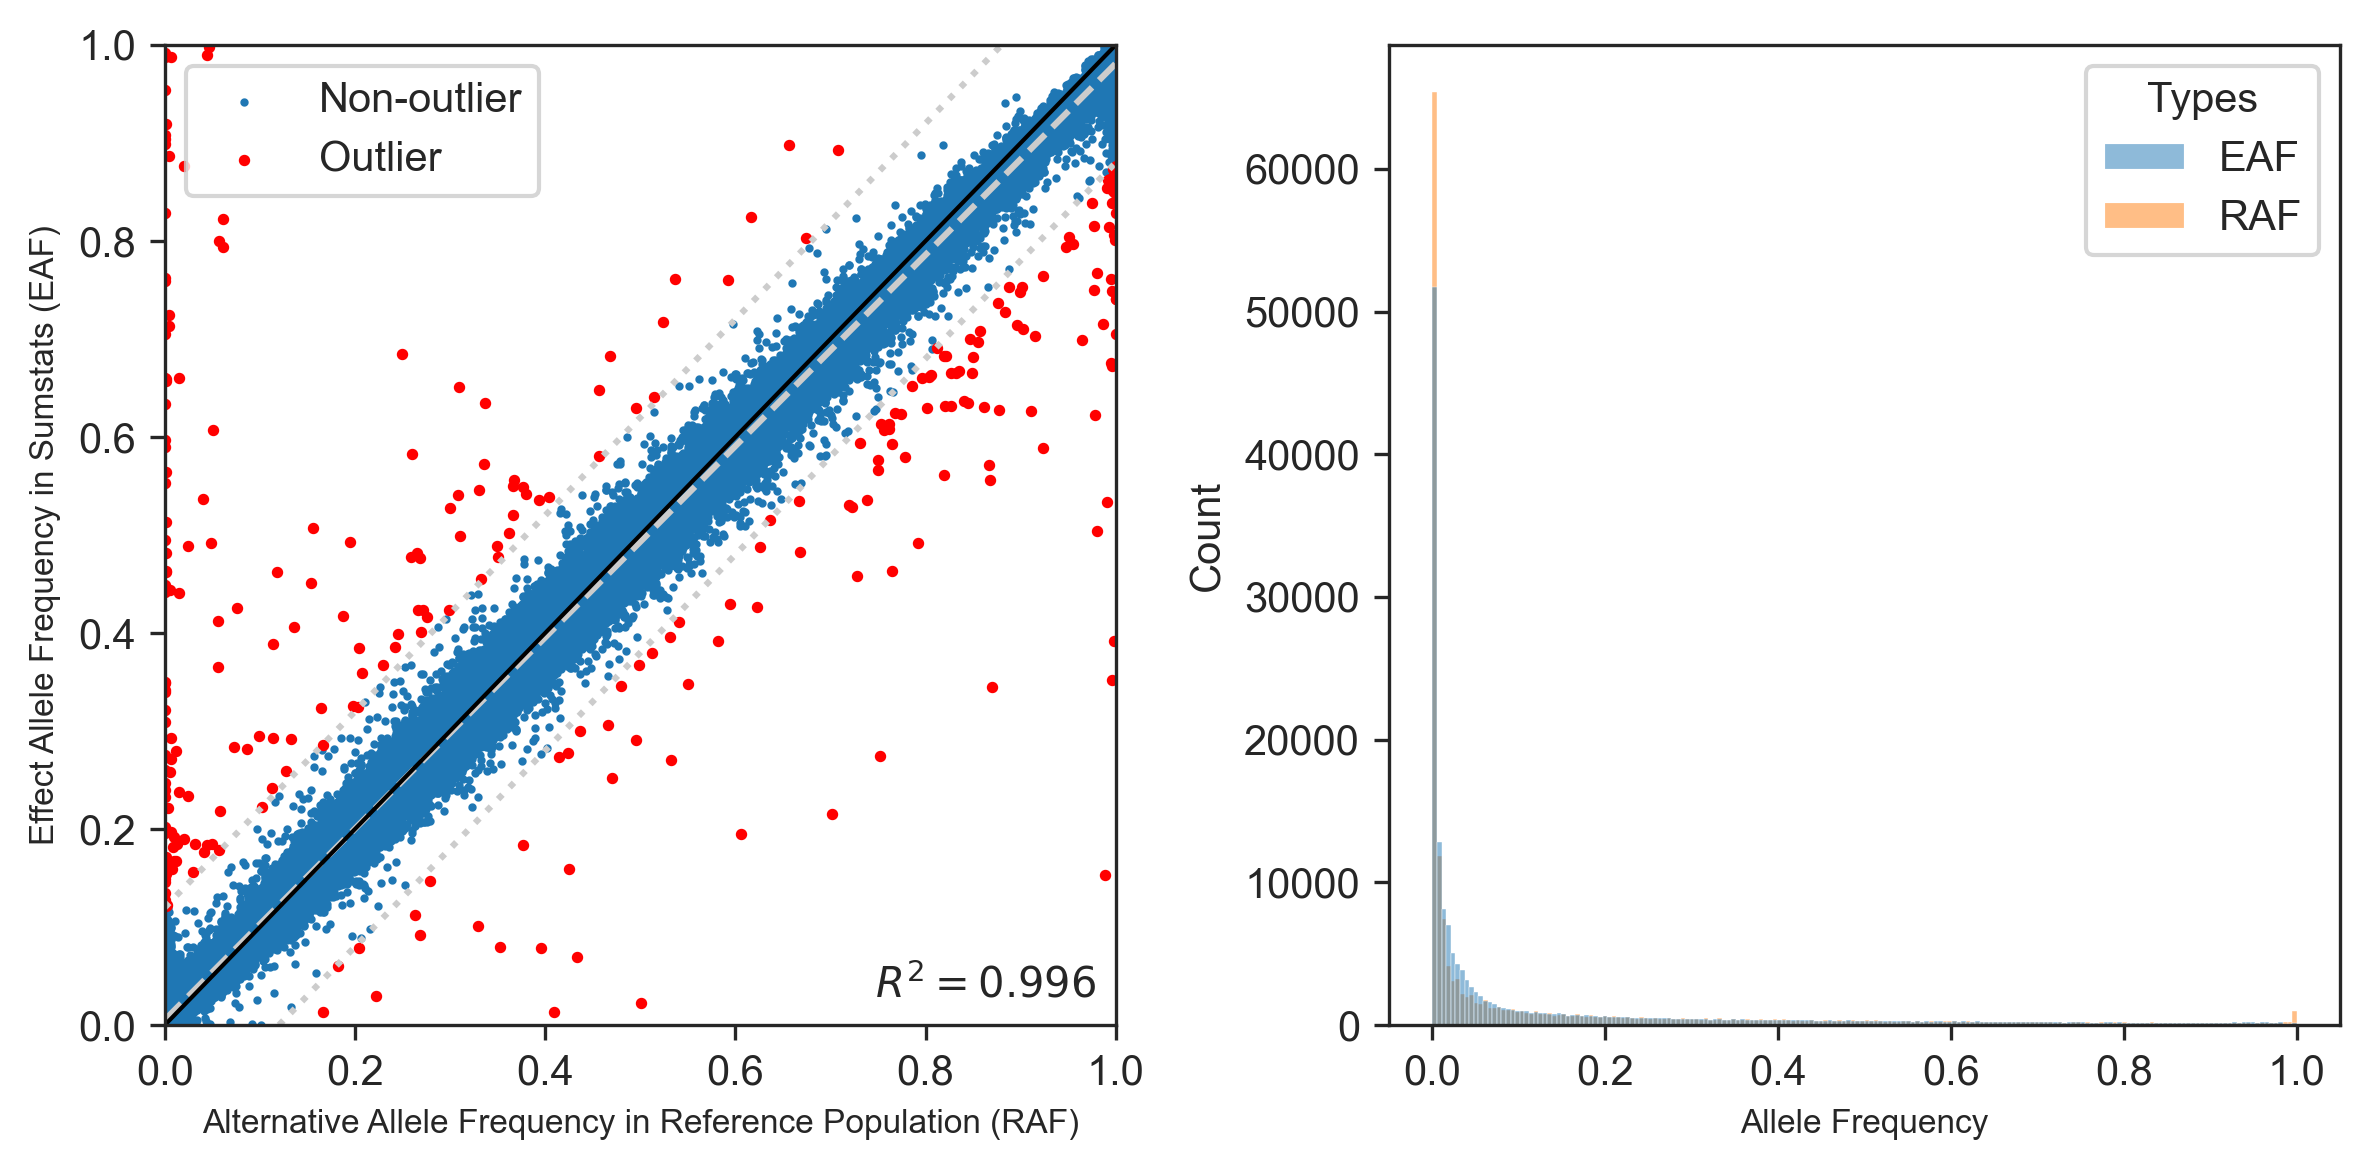

In [82]:
cad1m_sumstats_sample.plot_daf(threshold=0.12)

In [ ]:
# cad1m_sumstats.plot_daf(threshold=0.12)

In [ ]:
# del cad1m_sumstats_sample

##### Summary

So in summary we have done:

- a basic check, making sure the chr, pos, alleles are all in order
- multi-allelic, weird chromosomes, and duplicate variants are removed
- data are harmonized, such that the rsID is added, the alleles are relative to the references (and flipped if needed)

> Note, while we do calculate the difference in allele frequencies between the datasets and the reference, we **do not** filter on this for the purpose of sharing through _GWAS Catalog_.


In [83]:
print("The parsed and harmonized SumStats object:\n")

cad1m_sumstats.data

The parsed and harmonized SumStats object:



,SNPID,CHR,POS,EA,NEA,EAF,BETA,SE,P,N,DIRECTION,STATUS,Cases,Effective_Cases,HetPVal,HetISq,Meta_analysis,Cohorts,rsID
0,1:61743:G:C,1,61743,C,G,0.0061,-0.116327,0.079006,0.14090,538622,-???????+??,1930009,41651.0,18141.4,0.45400,0.0,Cardiogram,"UKBB-SAIGE, 1000G, EPIC, GerMIFs5, GerMIFs6, G...",<NA>
1,1:88370:G:A,1,88370,A,G,0.0033,-0.011699,0.093565,0.90050,538622,-???????+??,1930009,41651.0,22939.1,0.14960,51.8,Cardiogram,"UKBB-SAIGE, 1000G, EPIC, GerMIFs5, GerMIFs6, G...",<NA>
2,1:108382:C:A,1,108382,A,C,0.0008,0.263852,0.174365,0.13020,538622,+???????-??,1930009,41651.0,26336.9,0.33440,0.0,Cardiogram,"UKBB-SAIGE, 1000G, EPIC, GerMIFs5, GerMIFs6, G...",<NA>
3,1:233476:G:A,1,233476,A,G,0.0055,0.094606,0.081840,0.24770,538622,+???????-??,1930009,41651.0,17869.6,0.09955,63.1,Cardiogram,"UKBB-SAIGE, 1000G, EPIC, GerMIFs5, GerMIFs6, G...",<NA>
4,1:526832:G:C,1,526832,C,G,0.0367,-0.001923,0.025343,0.93950,829210,+?????-????,1930009,72859.0,50163.8,0.44480,0.0,Cardiogram,"UKBB-SAIGE, 1000G, EPIC, GerMIFs5, GerMIFs6, G...",<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20035531,22:51238318:A:T,22,51238318,T,A,0.0035,0.015020,0.083114,0.85660,565359,-???????+?+,1930019,59538.0,33829.0,0.14750,47.7,Cardiogram,"UKBB-SAIGE, 1000G, EPIC, GerMIFs5, GerMIFs6, G...",<NA>
20035532,22:51238328:A:C,22,51238328,C,A,0.0031,0.069523,0.097932,0.47780,565359,+???????-?-,1930019,59538.0,38407.9,0.53570,0.0,Cardiogram,"UKBB-SAIGE, 1000G, EPIC, GerMIFs5, GerMIFs6, G...",<NA>
20035533,22:51238333:T:C,22,51238333,C,T,0.0024,0.021590,0.132123,0.87020,538622,-???????+??,1930019,41651.0,24170.7,0.20370,38.1,Cardiogram,"UKBB-SAIGE, 1000G, EPIC, GerMIFs5, GerMIFs6, G...",<NA>
20035534,22:51238513:C:G,22,51238513,G,C,0.0002,-0.005830,0.262561,0.98230,829210,-?????+????,1930019,72859.0,53353.4,0.60090,0.0,Cardiogram,"UKBB-SAIGE, 1000G, EPIC, GerMIFs5, GerMIFs6, G...",<NA>


### Save or open data

Let's save (or open) the summary statistics object for future reference.


In [84]:
import gwaslab as gl

gl.dump_pickle(
    cad1m_sumstats,
    os.path.join(
        GWASCatalog_loc + "/META_" + PHENOTYPE + "_" + SEX + "_" + POPULATION + ".gwaslab.pkl",
    ),
    overwrite=True,
)

2024/10/23 12:52:27 Start to dump the Sumstats Object.
2024/10/23 12:52:27  -Dump the Sumstats Object to :  GWASCatalog/META_CAD_BOTH_EUR.gwaslab.pkl
2024/10/23 12:52:57 Finished dumping.


In [85]:
import gwaslab as gl

cad1m_sumstats.log.show()

cad1m_sumstats.log.save(
    os.path.join(
        GWASCatalog_loc + "/META_" + PHENOTYPE + "_" + SEX + "_" + POPULATION + ".b37.gwaslab.log",
    )
)

2024/10/18 11:05:00 Sumstats Object created.
2024/10/18 11:05:00 GWASLab v3.4.46 https://cloufield.github.io/gwaslab/
2024/10/18 11:05:00 (C) 2022-2024, Yunye He, Kamatani Lab, MIT License, gwaslab@gmail.com
2024/10/18 11:05:00 Start to initialize gl.Sumstats from pandas DataFrame ...
2024/10/18 11:05:26  -Reading columns          : CHR,BP,N,EAF,Effective_Cases,Effect,effect_allele,Direction,other_allele,StdErr,Meta_analysis,Cases,HetISq,Cohorts,P-value,MarkerName,HetPVal
2024/10/18 11:05:26  -Renaming columns to      : CHR,POS,N,EAF,Effective_Cases,BETA,EA,DIRECTION,NEA,SE,Meta_analysis,Cases,HetISq,Cohorts,P,SNPID,HetPVal
2024/10/18 11:05:26  -Current Dataframe shape : 20073070  x  17
2024/10/18 11:05:49  -Initiating a status column: STATUS ...
2024/10/18 11:05:49  -Genomic coordinates are based on GRCh37/hg19...
2024/10/18 11:05:59 Start to reorder the columns...v3.4.46
2024/10/18 11:05:59  -Current Dataframe shape : 20073070 x 18 ; Memory usage: 2511.71 MB
2024/10/18 11:05:59  -Reo

### Load pickled data


In [ ]:
# for future reference to open the pickle file
cad1m_sumstats = gl.load_pickle(
    os.path.join(
        GWASCatalog_loc + "/META_" + PHENOTYPE + "_" + POPULATION + "_" + SEX + ".gwaslab.pkl")
)

##### Parquet

Save it as a parquet for easy loading as a dataframe in other programs (_e.g._ `R`).


In [86]:
import pyarrow as pa
import pyarrow.parquet as pq

# Convert DataFrame to Apache Arrow Table
temp_table = pa.Table.from_pandas(cad1m_sumstats.data)

# Parquet with Brotli compression
pq.write_table(
    temp_table,
    os.path.join(
        GWASCatalog_loc + "/META_" + PHENOTYPE + "_" + SEX + "_" + POPULATION + ".b37.gwaslab.parquet",
    ),
    compression="BROTLI",
)
# we delete the temporary table object
del temp_table

### FUMA


In [87]:
cad1m_sumstats.to_format(
    os.path.join(GWASCatalog_loc + "/META_" + PHENOTYPE + "_" + SEX + "_" + POPULATION + ".b37.gwaslab"),
    fmt="fuma",
    build="19",
)

ValueError: Please select a format to output

### Filtering


Let's filter based on the following:

- CAVEAT == None


In [ ]:
cad1m_sumstats.data.dtypes

In [ ]:
# cad1m_sumstats_qc = cad1m_sumstats.filter_value(
#     '(EAF>=0.01 & EAF<0.99 & DF>=1) | CAVEAT==None'
# )

# #cad1m_sumstats_qc = cimt_data_sumstats.filter_value('CAVEAT== None')

In [ ]:
cad1m_sumstats_qc.data

In [ ]:
cad1m_sumstats_qc.summary()

In [ ]:
cad1m_sumstats_qc.lookup_status()

In [ ]:
import gwaslab as gl

gl.dump_pickle(
    cad1m_sumstats_qc,
    os.path.join(
        GWASCatalog_loc + "/META_" + PHENOTYPE + "_" + SEX + "_" + POPULATION + ".b37.gwaslab.qc.pkl",
    ),
    overwrite=True,
)


In [ ]:
cad1m_sumstats_qc.log.show()

cad1m_sumstats_qc.log.save(
    os.path.join(
        GWASCatalog_loc + "/META_" + PHENOTYPE + "_" + SEX + "_" + POPULATION + ".b37.gwaslab.qc.log",
    )
)

#### Load pickled data -- after QC


In [ ]:
# cimt_data_sumstats_qc = gl.load_pickle(
#     os.path.join(
#         GWAS_RES_loc,
#         "meta_analysis/" + SUBSTUDY_WOMEN + "/AIS_WOMEN_" + POPULATION + "_b37_qc.gwaslab.pkl",
#     )
# )


### Visualisations

Here we attempt to create a genome-wide plot annotating significant genes.

#### Manhattan and stratified QQ plots

Here we create an automatically annotated Manhattan plot. Annotation is based on hg19 (GRCh37), ensembl 87 (https://ftp.ensembl.org/pub/grch37/release-109/gtf/homo_sapiens/).


In [ ]:
# # manhattan and qq plot
# cimt_data_sumstats.plot_mqq(
#     skip=2,
#     cut=10,
#     sig_line=True,
#     sig_level=5e-8,
#     anno="GENENAME",
#     anno_style="right",
#     windowsizekb=500,
#     arm_offset=2,
#     repel_force=0.02,  # default 0.01
#     use_rank=True,
#     build="19",
#     # mode="m",
#     stratified=True,
#     drop_chr_start=True,
#     # figargs={"figsize": (25, 15), "dpi": 300},
#     title="" + PHENOTYPE + "_" + SEX + "_" + POPULATION + "",
#     save=os.path.join(
#         PLOTS_loc, "manhattan.500kb.300dpi." + PHENOTYPE + "_" + SEX + "_" + POPULATION + ".pdf"),
#     saveargs={"dpi": 300},
#     verbose=True,
# )

In [ ]:
# manhattan and qq plot
cimt_data_sumstats_female.plot_mqq(
    skip=2,
    cut=10,
    sig_line=True,
    sig_level=5e-8,
    anno="GENENAME",
    anno_style="right",
    windowsizekb=500,
    arm_offset=2,
    repel_force=0.02,  # default 0.01
    use_rank=True,
    build="19",
    # mode="m",
    stratified=True,
    drop_chr_start=True,
    # figargs={"figsize": (25, 15), "dpi": 300},
    title="" + PHENOTYPE + "_" + SEX1 + "_" + POPULATION + "",
    # save=os.path.join(
    #     PLOTS_loc, "manhattan.500kb.300dpi." + PHENOTYPE + "_" + SEX1 + "_" + POPULATION + ".pdf"),
    # saveargs={"dpi": 300},
    verbose=True,
)

In [ ]:
# manhattan and qq plot
cimt_data_sumstats_qc_female.plot_mqq(
    skip=2,
    cut=10,
    sig_line=True,
    sig_level=5e-8,
    anno="GENENAME",
    anno_style="right",
    windowsizekb=500,
    arm_offset=2,
    repel_force=0.02,  # default 0.01
    use_rank=True,
    build="19",
    # mode="m",
    stratified=True,
    drop_chr_start=True,
    # figargs={"figsize": (25, 15), "dpi": 300},
    title="" + PHENOTYPE + "_" + SEX1 + "_" + POPULATION + "_" + "QC" + "",
    # save=os.path.join(
    #     PLOTS_loc, "manhattan.500kb.300dpi." + PHENOTYPE + "_" + SEX1 + "_" + POPULATION + ".QC.pdf"),
    # saveargs={"dpi": 300},
    verbose=True,
)

In [ ]:
# manhattan and qq plot
cimt_data_sumstats_male.plot_mqq(
    skip=2,
    cut=10,
    sig_line=True,
    sig_level=5e-8,
    anno="GENENAME",
    anno_style="right",
    windowsizekb=500,
    arm_offset=2,
    repel_force=0.02,  # default 0.01
    use_rank=True,
    build="19",
    # mode="m",
    stratified=True,
    drop_chr_start=True,
    # figargs={"figsize": (25, 15), "dpi": 300},
    title="" + PHENOTYPE + "_" + SEX2 + "_" + POPULATION + "",
    # save=os.path.join(
    #     PLOTS_loc, "manhattan.500kb.300dpi." + PHENOTYPE + "_" + SEX2 + "_" + POPULATION + ".pdf"),
    # saveargs={"dpi": 300},
    verbose=True,
)

In [ ]:
# manhattan and qq plot
cimt_data_sumstats_qc_male.plot_mqq(
    skip=2,
    cut=10,
    sig_line=True,
    sig_level=5e-8,
    anno="GENENAME",
    anno_style="right",
    windowsizekb=500,
    arm_offset=2,
    repel_force=0.02,  # default 0.01
    use_rank=True,
    build="19",
    # mode="m",
    stratified=True,
    drop_chr_start=True,
    # figargs={"figsize": (25, 15), "dpi": 300},
    title="" + PHENOTYPE + "_" + SEX2 + "_" + POPULATION + "_" + "QC" + "",
    # save=os.path.join(
    #     PLOTS_loc, "manhattan.500kb.300dpi." + PHENOTYPE + "_" + SEX2 + "_" + POPULATION + ".QC.pdf"),
    # saveargs={"dpi": 300},
    verbose=True,
)

### Top loci

We inventory the top loci.


In [ ]:
# cimt_data_sumstats.get_lead(anno=True, sig_level=5e-8, verbose=True)

In [ ]:
cimt_data_sumstats_female.get_lead(anno=True, sig_level=5e-8, verbose=True)

In [ ]:
cimt_data_sumstats_male.get_lead(anno=True, sig_level=5e-8, verbose=True)

In [ ]:
cimt_data_sumstats_female.get_lead(anno=True, sig_level=5e-6, verbose=True)

In [ ]:
cimt_data_sumstats_male.get_lead(anno=True, sig_level=5e-6, verbose=True)

In [ ]:
# highlight	list	list of loci (tuples of CHR and POS) to highlight for both sumstats. For example, highlight=[(2,2153874),(5,124289158)]	None
# highlight1	list	list of loci (tuples of CHR and POS) to highlight for sumstats1. For example, highlight1=[(2,2153874),(5,124289158)]	None
# highlight2	list	list of loci (tuples of CHR and POS) to highlight for sumstats2. For example, highlight2=[(2,2153874),(5,124289158)]	None
# highlight_windowkb	int	window size for highlighting loci	500
# highlight_color	color	color for highlighting loci	"#CB132D"

female_vs_male_sumstats = gl.plot_miami(path1=cimt_data_sumstats_female,
                                     path2=cimt_data_sumstats_male,
                                     titles=[SEX1, SEX2],
                                     titles_pad=[0.15, 0.0],
                                     anno="GENENAME",
                                     anno_set=[(3, 116367226), (15, 87431547)],
                                     highlight=[(3, 116367226),
                                                (15, 87431547)],
                                     highlight_windowkb=500,
                                      #  save=os.path.join(PLOTS_loc, "miami.500kb.300dpi." + POPULATION + "." + SEX1 + "_vs_" + SEX2 + ".pdf"),
                                      #saveargs={"dpi": 300}
                                     )

In [ ]:
# highlight	list	list of loci (tuples of CHR and POS) to highlight for both sumstats. For example, highlight=[(2,2153874),(5,124289158)]	None
# highlight1	list	list of loci (tuples of CHR and POS) to highlight for sumstats1. For example, highlight1=[(2,2153874),(5,124289158)]	None
# highlight2	list	list of loci (tuples of CHR and POS) to highlight for sumstats2. For example, highlight2=[(2,2153874),(5,124289158)]	None
# highlight_windowkb	int	window size for highlighting loci	500
# highlight_color	color	color for highlighting loci	"#CB132D"

female_vs_male_sumstats = gl.plot_miami(path1=cimt_data_sumstats_qc_female,
                                     path2=cimt_data_sumstats_qc_male,
                                     titles=[SEX1 + "-QC", SEX2 + "-QC"],
                                     titles_pad=[0.15, 0.0],
                                     anno="GENENAME",
                                     anno_set=[(3, 116367226), (15, 87431547)],
                                     highlight=[(3, 116367226),
                                                (15, 87431547)],
                                     highlight_windowkb=500,
                                      #  save=os.path.join(PLOTS_loc, "miami.500kb.300dpi." + POPULATION + "." + SEX1 + "_vs_" + SEX2 + ".QC.pdf"),
                                      #  saveargs={"dpi": 300}
                                     )

### Effect Comparison

Get the targets for `PHENOTYPE` and compare SEX1 and SEX2


In [ ]:
# https://cloufield.github.io/gwaslab/EffectSize/

gl.compare_effect(
    cimt_data_sumstats_female,
    cimt_data_sumstats_male,
    mode="beta",
    #label=[SEX1, SEX2],
    #label=[PHENOTYPE, "Females", "Males"],
    label=[SEX1,SEX2,"Both","None"],
    sig_level=5e-6,
    legend_title=r"$ P < 5 x 10^{-6}$ in:",
    legend_title2=r"Heterogeneity test:",
    legend_pos="upper left",
    #  legend_args=None,
    xylabel_prefix="Per-allele effect size in ",
    is_reg=True,
    is_45_helper_line=True,
    # anno=True,
    # anno_min=0,
    # anno_min1=0,
    # anno_min2=0,
    # anno_diff=0,
    # is_q=False,
    q_level=0.05,
    # anno_het=False,
    # r_se=False,
    #  fdr=False,
    #  legend_mode="full",
     save=True,
    # saveargs=None,
    verbose=False,
)

In [ ]:
# https://cloufield.github.io/gwaslab/EffectSize/

gl.compare_effect(
    cimt_data_sumstats_qc_female,
    cimt_data_sumstats_qc_male,
    mode="beta",
    #label=[SEX1, SEX2],
    #label=[PHENOTYPE, "Females", "Males"],
    label=[SEX1,SEX2,"Both","None"],
    sig_level=5e-6,
    legend_title=r"$ P < 5 x 10^{-6}$ in:",
    legend_title2=r"Heterogeneity test:",
    legend_pos="upper left",
    #  legend_args=None,
    xylabel_prefix="Per-allele effect size in ",
    is_reg=True,
    is_45_helper_line=True,
    # anno=True,
    # anno_min=0,
    # anno_min1=0,
    # anno_min2=0,
    # anno_diff=0,
    # is_q=False,
    q_level=0.05,
    # anno_het=False,
    # r_se=False,
    #  fdr=False,
    #  legend_mode="full",
     save=True,
    # saveargs=None,
    verbose=False,
)